# Urban Heat Island (UHI) Benchmark Notebook 

## Challenge Overview

<p align="justify">Welcome to the EY Open Science AI & Data Challenge 2025! The objective of this challenge is to build a machine learning model to predict urban heat island (UHI) hotspots in a city. By the end of the challenge, you will have developed a regression model capable of predicting the intensity of the UHI effect.

Participants will be given ground-level air temperature data in an index format, which was collected on 24th July 2021 on traverse points in the Bronx and Manhattan regions of New York city. This dataset constitutes traverse points (latitude and longitude) and their corresponding UHI (Urban Heat Island) index values. Participants will use this dataset to build a regression model to predict UHI index values for a given set of locations. It is important to understand that the UHI Index at any given location is indicative of the relative temperature elevation at that specific point compared to the city's average temperature.

This challenge is designed for participants with varying skill levels in data science and programming, offering a great opportunity to apply your knowledge and enhance your capabilities in the field.</p>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been constructed to predict the Urban Heat Island (UHI) index using features from the Sentinel-2 satellite dataset as predictor variables. In this demonstration, we utilized three features from the Sentinel-2 dataset: band B01 (Coastal Aerosol), band B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from bands B04 (Red) and B08 (Near Infrared). A random forest regression model was then trained using these features.
    
These features were extracted from a GeoTIFF image created by the Sentinel-2 sample notebook. For the sample model shown in this notebook, data from a single day (24th July 2021) was considered, assuming that the values of bands B01, B04, B06, and B08 for this specific date are representative of the UHI index behavior at any location. Participants should review the details of the Sentinel-2 sample notebook to gain an understanding of the data and options for modifying the output product. 
    
</p>

<p align="justify">Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2-Level-2A notebook</a> found in the Planetary Computer portal.</p>

<p align="justify">Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</p>


## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

In [1]:
!pip install planetary_computer rasterio rioxarray pystac_client rasterstats -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 58.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 7.8 MB/s eta 0:00:00


In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm



In [3]:
from catboost import CatBoostRegressor

## Response Variable

Before building the model, we need to load in the Urban Heat Island (UHI) index training dataset. We have curated data for the New York region. The dataset consists of geo-locations (Longitude and Latitude), with additional fields including date & time of data collection and the UHI index for each location. 

<h10 style="color:rgb(255, 255, 0)"><strong>Note: Participants are strictly prohibited from using Longitude and Latitude values as features in building their machine learning models. These values should only be utilized for understanding the attributes and characteristics of the locations. Submissions that employ longitude and latitude values as model features will be disqualified.</strong></h10>

<h10 style="color:rgb(255, 255, 0)"><strong>Incorporating latitude and longitude data in their raw forms or through any form of manipulation—including multiplication, embedding, or conversion to polar coordinates—as predictive features in your model is strictly prohibited, as it can compromise the adaptability of your model across diverse scenarios. This prohibition extends to calculating the distance from a reference point and using it as a feature, which is essentially a transformation of the original geographical coordinates into a new feature form. Submissions that include these types of features will be considered non-compliant and will be disqualified.</strong></h10>

In [123]:
# Load the training data from csv file and display the first few rows to inspect the data

Data_path='/kaggle/input/urban-heats-index-data/'
ground_df = pd.read_csv(Data_path+"Training_data_uhi_index_2025-02-18.csv")
ground_df.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634


## Predictor Variables

<p align="justify">Now that we have our UHI data, it is time to gather the predictor variables from the Sentinel-2 dataset. Participants should review the provided Sentinel-2 sample notebook as it was used to create a sample GeoTIFF for this models. For a more in-depth look regarding the Sentinel-2 dataset and how to query it, see the Microsoft Planetary Computer example <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2 supplementary notebook</a>. </p>

<p align="justify">Sentinel-2 optical data provides high-resolution imagery that is sensitive to land surface characteristics, which are crucial for understanding urban heat dynamics. Band values such as B01 (Coastal aerosol), B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from B04 (Red) and B08 (Near Infrared) help us in estimating the UHI index. Hence, we are choosing B01, B06, and NDVI as predictor variables for this experiment.</p>

<ul> 
<li>B01 - Reflectance values from the Coastal aerosol band, which help in assessing aerosol presence and improving atmospheric correction.</li>

<li>B06 - Reflectance values from the Red Edge band, which provide useful information for detecting vegetation, water bodies, and urban surfaces.</li>

<li>NDVI - Derived from B04 (Red) and B08 (Near Infrared), NDVI is an important indicator for vegetation health and land cover.</li>
</ul>


<h4 style="color:rgb(255, 255, 0)"><strong>Tip 1</strong></h4>
<p align="justify">Participants might explore other combinations of bands from the Sentinel-2 and from other satellite datasets as well. For example, you can use mathematical combinations of bands to generate various indices </a> which can then be used as features in your model. These bands or indices may provide insights into surface characteristics, vegetation, or built-up areas that could influence UHI patterns.

### Analyze the Sentinel-2 Data

<p align="justify">To obtain the Sentinel-2 data, we created a GeoTIFF image for a specific date and area of interest, which in this case is the Bronx and Manhattan regions of New York. The GeoTIFF product allows us to extract the relevant band values. In this example, we extracted B01 (Coastal Aerosol), B04 (Red), B06 (Red Edge), and B08 (Near Infrared) values for a single day (24th July, 2021). Participants should review the provided Sentinel-2 sample notebook for common output images (RGB, NDVI) and methods to alter the output.</p>

### Methods of Extracting Band Values from Sentinel-2 Data

There are two common methods to extract band values from Sentinel-2 data:

<ul>
    <li><strong>Using API Calls:</strong> Retrieve band values directly from Sentinel-2 datasets via APIs, such as the <code>planetary_computer</code>.</li>
</ul>
<ul>
    <li><strong>Using GeoTIFF Images:</strong> Create and download a GeoTIFF image containing the desired bands and extract the band values locally. The GeoTIFF image can represent any desired time period (single date or time series mosaic) and include any number of spectral bands.</li>
</ul>

Participants can select any of these approaches as per their convenience. Since our dataset is large, the API method can be time-consuming and resource-intensive. Therefore, in this sample notebook, we have opted for the second method and extracted the values for bands B01, B04, B08, and B06. Please refer to the Sentinel-2 sample notebook for details about the creation of the GeoTIFF image. 

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 2</strong></h4>
<p align="justify"> Rather than extracting the bands for a single day coincident with the ground-based data collection, participants might explore other options to improve data quality. For example, one could select a different single date with minimal or no cloud cover or generate a median mosaic using several scenes within a time series. See the Sentinel-2 sample notebook for examples.</p>

### Downloading GeoTIFF Image

For building a sample model in this demonstration notebook, we have downloaded a GeoTIFF file locally for a single day (24th July 2021). The file is named <b>S2_sample.tiff</b>. This GeoTIFF file contains values of four bands: Band B01, Band B04, Band B06 and Band B08. In the subsequent section, we will use this GeoTIFF file to extract the band values for the geo-locations given in the training dataset to create the features.

First, let’s visualize the bands of the downloaded GeoTIFF image.

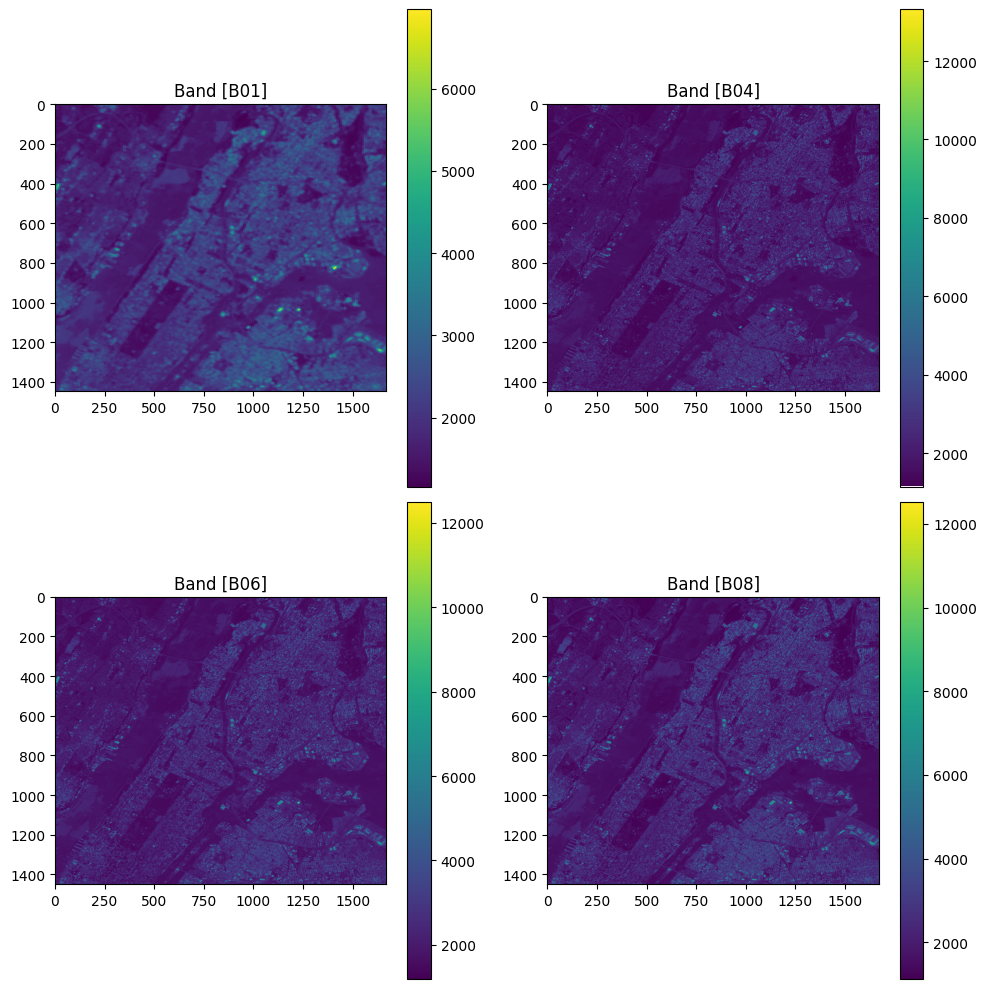

In [5]:
# Reads and plots four bands (B04, B08, B06, B01) from the GeoTIFF file.

# Open the GeoTIFF file
tiff_path = Data_path + "S2_nomedian_update_sample.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as src1:
    band1 = src1.read(1)  # Band [B01]
    band2 = src1.read(2)  # Band [B04]
    band3 = src1.read(3)  # Band [B06]
    band4 = src1.read(4)  # Band [B08]
    band5 = src1.read(5)
    band6 = src1.read(6)
    band7 = src1.read(7)
    band8 = src1.read(8)
    band9 = src1.read(9)
    band10 = src1.read(10)
    band11 = src1.read(11)

# Plot the bands in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot the first band (B01)
im1 = axes[0].imshow(band1, cmap='viridis')
axes[0].set_title('Band [B01]')
fig.colorbar(im1, ax=axes[0])

# Plot the second band (B04)
im2 = axes[1].imshow(band2, cmap='viridis')
axes[1].set_title('Band [B04]')
fig.colorbar(im2, ax=axes[1])

# Plot the third band (B06)
im3 = axes[2].imshow(band3, cmap='viridis')                 
axes[2].set_title('Band [B06]')
fig.colorbar(im3, ax=axes[2])

# Plot the fourth band (B08)
im4 = axes[3].imshow(band4, cmap='viridis')
axes[3].set_title('Band [B08]')
fig.colorbar(im4, ax=axes[3])

plt.tight_layout()
plt.show()


<h4 style="color:rgb(255, 255, 0)"><strong>Tip 3</strong></h4>

Instead of a single point data extraction, participants might explore the approach of creating a focal buffer around the locations (e.g., 50 m, 100 m, 150 m etc). For example, if the specified distance was 50 m and the specified band was “Band 2”, then the value of the output pixels from this analysis would reflect the average values in band 2 within 50 meters of the specific location. This approach might help reduction in error associated with spatial autocorrelation. In this demonstration notebook, we are extracting the band data for each of the locations without creating a buffer zone.




### Extracting Band Values from the GeoTIFF Image


In [6]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data(tiff_path, csv_path):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)
    
    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    B01_values = []
    B02_values = []
    B03_values = []
    B04_values = []
    B05_values = []
    B06_values = []
    B07_values = []
    B08_values = []
    BA8_values = []
    B11_values = []
    B12_values = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
    
        B01_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B01_values.append(B01_value)
    
        B02_value = data.sel(x=lon, y=lat, band=2, method="nearest").values
        B02_values.append(B02_value)
        
        B03_value = data.sel(x=lon, y=lat, band=3, method="nearest").values
        B03_values.append(B03_value)
    
        B04_value = data.sel(x=lon, y=lat, band=4, method="nearest").values
        B04_values.append(B04_value)
        
        B05_value = data.sel(x=lon, y=lat, band=5, method="nearest").values
        B05_values.append(B05_value)

        B06_value = data.sel(x=lon, y=lat, band=6, method="nearest").values
        B06_values.append(B06_value)

        B07_value = data.sel(x=lon, y=lat, band=7, method="nearest").values
        B07_values.append(B07_value)

        B08_value = data.sel(x=lon, y=lat, band=8, method="nearest").values
        B08_values.append(B08_value)

        BA8_value = data.sel(x=lon, y=lat, band=9, method="nearest").values
        BA8_values.append(BA8_value)

        B11_value = data.sel(x=lon, y=lat, band=10, method="nearest").values
        B11_values.append(B11_value)

        B12_value = data.sel(x=lon, y=lat, band=11, method="nearest").values
        B12_values.append(B12_value)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['B01'] = B01_values
    df['B02'] = B02_values
    df['B03'] = B03_values
    df['B04'] = B04_values
    df['B05'] = B05_values
    df['B06'] = B06_values
    df['B07'] = B07_values
    df['B08'] = B08_values
    df['BA8'] = BA8_values
    df['B11'] = B11_values
    df['B12'] = B12_values
    
    return df


In [124]:
# Mapping satellite data with training data.
final_data = map_satellite_data(Data_path +'S2_nomedian_update_sample.tiff', Data_path+'Training_data_uhi_index_2025-02-18.csv')

Mapping values: 100%|██████████| 11229/11229 [03:01<00:00, 61.74it/s]


In [8]:
from rasterstats import zonal_stats
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

lat_values = ground_df["Latitude"].values
lon_values = ground_df["Longitude"].values

# Create a GeoDataFrame from the Xarray dataset
gdf = gpd.GeoDataFrame(
    geometry=[Point(lon, lat) for lon, lat in zip(lon_values, lat_values)],
    crs="EPSG:4326"
)

gdf

,geometry
0,POINT (-73.90917 40.81311)
1,POINT (-73.90919 40.81305)
2,POINT (-73.90922 40.81298)
3,POINT (-73.90924 40.81291)
4,POINT (-73.90926 40.81285)
...,...
11224,POINT (-73.95705 40.79033)
11225,POINT (-73.95706 40.79031)
11226,POINT (-73.95709 40.79027)
11227,POINT (-73.95711 40.79025)


In [9]:
gdf_try=gdf.copy()

gdf_try=gdf_try.to_crs(epsg='26918')

gdf_try['buffer_50m'] =gdf_try.geometry.buffer(50)



In [10]:
gdf_try['buffer_50m'][0].bounds

(591950.2226022917, 4518532.907787419, 592050.2226022917, 4518632.907787419)

In [11]:
gdf_try.to_crs(epsg=4326)

,geometry,buffer_50m
0,POINT (-73.90917 40.81311),"POLYGON ((592050.223 4518582.908, 592049.982 4..."
1,POINT (-73.90919 40.81305),"POLYGON ((592048.621 4518576.041, 592048.380 4..."
2,POINT (-73.90922 40.81298),"POLYGON ((592046.324 4518568.610, 592046.083 4..."
3,POINT (-73.90924 40.81291),"POLYGON ((592044.171 4518560.812, 592043.930 4..."
4,POINT (-73.90926 40.81284),"POLYGON ((592042.993 4518553.766, 592042.753 4..."
...,...,...
11224,POINT (-73.95705 40.79033),"POLYGON ((588041.777 4516005.720, 588041.537 4..."
11225,POINT (-73.95706 40.79031),"POLYGON ((588040.686 4516002.931, 588040.445 4..."
11226,POINT (-73.95709 40.79027),"POLYGON ((588038.205 4515998.646, 588037.964 4..."
11227,POINT (-73.95711 40.79025),"POLYGON ((588036.680 4515996.777, 588036.439 4..."


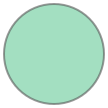

In [12]:
gdf_try.buffer_50m[0]

In [13]:
gdf_try['buffer_50m']=gdf_try.buffer_50m.to_crs(epsg='4236')

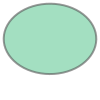

In [14]:
gdf_try.buffer_50m[0]

In [15]:
# # Convert CRS to projected (buffering works better in meters)
gdf = gdf.to_crs(epsg=26918)

# Create buffer zones of different sizes
gdf["buffer_50m"] = gdf.geometry.buffer(50,)    # 100-meter buffer
gdf["buffer_100m"] = gdf.geometry.buffer(100)   # 500-meter buffer
gdf["buffer_150m"] = gdf.geometry.buffer(150) # 1 km buffer

# Convert back to lat/lon for mapping
gdf["buffer_50m"] = gdf["buffer_50m"].to_crs(epsg=4326) #38254
gdf["buffer_100m"] = gdf["buffer_100m"].to_crs(epsg=4326)
gdf["buffer_150m"] = gdf["buffer_150m"].to_crs(epsg=4326)

In [16]:
gdf

,geometry,buffer_50m,buffer_100m,buffer_150m
0,POINT (592000.223 4518582.908),"POLYGON ((-73.90857 40.81310, -73.90858 40.813...","POLYGON ((-73.90798 40.81310, -73.90799 40.813...","POLYGON ((-73.90739 40.81309, -73.90740 40.812..."
1,POINT (591998.621 4518576.041),"POLYGON ((-73.90859 40.81304, -73.90860 40.813...","POLYGON ((-73.90800 40.81303, -73.90801 40.812...","POLYGON ((-73.90741 40.81303, -73.90742 40.812..."
2,POINT (591996.324 4518568.610),"POLYGON ((-73.90862 40.81297, -73.90863 40.812...","POLYGON ((-73.90803 40.81297, -73.90804 40.812...","POLYGON ((-73.90744 40.81296, -73.90745 40.812..."
3,POINT (591994.171 4518560.812),"POLYGON ((-73.90865 40.81290, -73.90865 40.812...","POLYGON ((-73.90806 40.81290, -73.90806 40.812...","POLYGON ((-73.90746 40.81289, -73.90747 40.812..."
4,POINT (591992.993 4518553.766),"POLYGON ((-73.90866 40.81284, -73.90867 40.812...","POLYGON ((-73.90807 40.81283, -73.90808 40.812...","POLYGON ((-73.90748 40.81283, -73.90749 40.812..."
...,...,...,...,...
11224,POINT (587991.777 4516005.720),"POLYGON ((-73.95646 40.79033, -73.95646 40.790...","POLYGON ((-73.95586 40.79032, -73.95587 40.790...","POLYGON ((-73.95527 40.79032, -73.95528 40.790..."
11225,POINT (587990.686 4516002.931),"POLYGON ((-73.95647 40.79030, -73.95647 40.790...","POLYGON ((-73.95588 40.79030, -73.95589 40.790...","POLYGON ((-73.95529 40.79029, -73.95530 40.790..."
11226,POINT (587988.205 4515998.646),"POLYGON ((-73.95650 40.79026, -73.95650 40.790...","POLYGON ((-73.95591 40.79026, -73.95592 40.790...","POLYGON ((-73.95532 40.79025, -73.95533 40.790..."
11227,POINT (587986.680 4515996.777),"POLYGON ((-73.95652 40.79025, -73.95652 40.790...","POLYGON ((-73.95593 40.79024, -73.95593 40.790...","POLYGON ((-73.95533 40.79024, -73.95534 40.790..."


In [19]:
final_data['longitude'] = ground_df['Longitude']
final_data['latitude'] = ground_df['Latitude']

In [20]:
final_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,BA8,B11,B12,longitude,latitude
0,1923.0,1960.0,1974.0,2082.0,2470.0,2667.0,2690.0,2690.0,2714.0,2704.0,2378.0,-73.909167,40.813107
1,1923.0,1960.0,1974.0,2082.0,2470.0,2667.0,2690.0,2690.0,2714.0,2704.0,2378.0,-73.909187,40.813045
2,1923.0,1708.0,2056.0,1802.0,2155.0,3121.0,3402.0,3802.0,3611.0,2698.0,2203.0,-73.909215,40.812978
3,1923.0,1644.0,1894.0,1782.0,2155.0,3121.0,3402.0,3602.0,3611.0,2698.0,2203.0,-73.909242,40.812908
4,1923.0,1680.0,1798.0,1804.0,2228.0,3051.0,3354.0,3446.0,3558.0,2743.0,2271.0,-73.909257,40.812845


In [ ]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
# See the Sentinel-2 sample notebook for more information about the NDVI index
final_data['NDVI'] = (final_data['B08'] - final_data['B04']) / (final_data['B08'] + final_data['B04'])
final_data['NDVI'] = final_data['NDVI'].replace([np.inf, -np.inf], np.nan) 

In [131]:
lst_filename = Data_path+"Landsat_median_update_LST.tiff"

In [132]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data_LST(tiff_path, csv_path):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)
    
    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    llwir1_values = []
   

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
    
        llwir1_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        llwir1_values.append(llwir1_value)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['llwir1'] = llwir1_values
    
    return df


In [133]:
lst_data = map_satellite_data_LST(lst_filename, Data_path+'Training_data_uhi_index_2025-02-18.csv')

Mapping values: 100%|██████████| 11229/11229 [00:15<00:00, 744.13it/s]


In [134]:
lst_data.head()

,llwir1
0,38.445211400000005
1,38.445211400000005
2,37.32410084000003
3,37.32410084000003
4,36.99255290000002


In [135]:
def map_satellite_data_additional(tiff_path, csv_path):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)
    
    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    green_values = []
    blue_values = []
    red_values = []
    nir08_values = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
    
        green_value = data.sel(x=lon, y=lat,  band=2, method="nearest").values
        green_values.append(green_value)
    
        blue_value = data.sel(x=lon, y=lat, band=3, method="nearest").values
        blue_values.append(blue_value)
        
        red_value = data.sel(x=lon, y=lat, band=1, method="nearest").values
        red_values.append(red_value)
    
        nir08_value = data.sel(x=lon, y=lat, band=4, method="nearest").values
        nir08_values.append(nir08_value)
        
       
    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['green'] = green_values
    df['blue'] = blue_values
    df['red'] = red_values
    df['nir08'] = nir08_values
    
    return df

In [136]:
additional_bands=map_satellite_data_additional(Data_path+'Additional_median_update_bands.tiff',Data_path+'Training_data_uhi_index_2025-02-18.csv')

Mapping values: 100%|██████████| 11229/11229 [01:03<00:00, 176.93it/s]


In [137]:
additional_bands.head()

,green,blue,red,nir08
0,0.14277374999999998,0.12117250000000002,0.15264624999999998,0.19854375000000002
1,0.14277374999999998,0.12117250000000002,0.15264624999999998,0.19854375000000002
2,0.07586625000000002,0.06437124999999999,0.0716175,0.26167
3,0.07586625000000002,0.06437124999999999,0.0716175,0.26167
4,0.09731624999999999,0.07068249999999998,0.08916249999999998,0.2620275


In [138]:
def map_sentinel_1_data(tiff_path, csv_path):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)
    
    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    green_values = []
    blue_values = []
  

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
    
        green_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        green_values.append(green_value)
    
        blue_value = data.sel(x=lon, y=lat, band=2, method="nearest").values
        blue_values.append(blue_value)
        
        
       
    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['vv'] = green_values
    df['vh'] = blue_values
    
    return df

In [139]:
sentinel1_data=map_sentinel_1_data(Data_path+'S1_median_update2_sample.tiff',Data_path+'Training_data_uhi_index_2025-02-18.csv')

Mapping values: 100%|██████████| 11229/11229 [00:32<00:00, 342.90it/s]


In [140]:
sentinel1_data

,vv,vh
0,2.4432566165924072,2.194512128829956
1,2.4432566165924072,2.194512128829956
2,2.370969772338867,2.2132718563079834
3,2.387298583984375,2.20268177986145
4,2.525782585144043,2.2900118827819824
...,...,...
11224,2.3330249786376953,2.0100977420806885
11225,2.313539505004883,2.0281665325164795
11226,2.313539505004883,2.0281665325164795
11227,2.313539505004883,2.0281665325164795


In [147]:
def get_more_features(data):  
    epsilon = 1e-8  # Small value to avoid division by zero
    # Existing indices
    data['ndvi'] = (data['nir08'] - data['red']) / (data['nir08'] + data['red'] + epsilon)
    data['evi'] = 2.5 * ((data['nir08'] - data['red']) / (data['nir08'] + 6 * data['red'] - 7.5 * data['blue'] + 1 + epsilon))
    data['ndwi'] = (data['green'] - data['nir08']) / (data['green'] + data['nir08'] + epsilon)
    data['ndbi'] = (data['B11'] - data['nir08']) / (data['B11'] + data['nir08'] + epsilon)
    L = 0.5
    data['savi'] = ((data['nir08'] - data['red']) / (data['nir08'] + data['red'] + L + epsilon)) * (1 + L)
    # data['nbr'] = (data['nir08'] - data['B12']) / (data['nir08'] + data['B12'] + epsilon)
    data['evi2'] = 2.5 * ((data['nir08'] - data['red']) / (data['nir08'] + 2.4 * data['red'] + 1 + epsilon))
    # data['msavi'] = (2 * data['nir08'] + 1 - np.sqrt((2 * data['nir08'] + 1)**2 - 8 * (data['nir08'] - data['red']))) / 2
    data['sr'] = data['nir08'] / (data['red'] + epsilon)
    data['gci'] = (data['nir08'] / (data['green'] + epsilon)) - 1
    data['sipi'] = (data['nir08'] - data['blue']) / ((data['nir08'] - data['red']) + epsilon)
    # data['msi'] = data['B11'] / (data['nir08'] + epsilon)
    data['nmdi'] = (data['nir08'] - (data['B11'] - data['B12'])) / ((data['nir08'] + (data['B11'] - data['B12'])) + epsilon)
    data['ri'] = data['red'] / data['green']
    data['gli'] = (2 * data['green'] - data['red'] - data['blue']) / (2 * data['green'] + data['red'] + data['blue'] + epsilon)
    data['blue_green_ratio'] = data['blue'] / (data['green'] + epsilon)
    data['green_red_ratio'] = data['green'] / (data['red'] + epsilon)

    data['ndi45'] = (data['red'] - data['blue']) / (data['red'] + data['blue'] + epsilon)  # Normalized Difference Index (45)
    data['si'] = (data['blue'] + data['green'] + data['red']) / 3  # Saturation Index


    
    # Assuming 'df' contains 'VV' and 'VH' columns
    data["VV/VH_Ratio"] = data["vv"] / data["vh"]
    data["VV_VH_Diff"] = data["vv"] - data["vh"]
    data["NDPI"] = (data["vv"] - data["vh"]) / (data["vv"] + data["vh"])
    # data["Log_Ratio"] = 10 * np.log10(data["vv"] / data["vh"])

    epsilon = 1e-6  # Small constant to prevent log10(0)
    # data["Log_Ratio"] = 10 * np.log10((data["vv"] + epsilon) / (data["vh"] + epsilon))

    # # Basic band ratios
    # data['red_nir_ratio'] = data['red'] / data['nir08']
    # data['nir_swir_ratio'] = data['nir08'] / data['B11']
    # data['blue_green_ratio'] = data['B02'] / data['B03']
    # data['swir1_swir2_ratio'] = data['B11'] /data['B12']

    # # Vegetation Indices
    # # data['nbr'] = (data['nir08'] - data['B12']) / (data['nir08'] + data['B12'])  # Normalized Burn Ratio
    # # data['ndmi'] = (data['nir08'] - data['B11']) / (data['nir08'] + data['B11'])  # Moisture Index
    # data['bsi'] = ((data['B11'] + data['red']) - (data['nir08'] + data['B02'])) / ((data['B11'] + data['red']) + (data['nir08'] + data['B02']))  # Bare Soil Index
    # data['rendvi'] = (data['B06'] - data['B05']) / (data['B06'] + data['B05'])  # Red-Edge NDVI
    # data['mcari'] = ((data['B05'] - data['B04']) - 0.2 * (data['B05'] - data['B03'])) / (data['B05'] + data['B04'])  # Chlorophyll Absorption Ratio


    return data

In [148]:
full_engineered= pd.concat([final_data,lst_data,additional_bands,sentinel1_data], axis=1).copy()

In [149]:
all_data=get_more_features(full_engineered)
all_data.head()

# print(all_data.columns[all_data.columns.duplicated()])

,B01,B02,B03,B04,B05,B06,B07,B08,BA8,B11,B12,llwir1,green,blue,red,nir08,vv,vh,ndvi,evi,ndwi,ndbi,savi,evi2,sr,gci,sipi,nmdi,ri,gli,blue_green_ratio,green_red_ratio,ndi45,si,VV/VH_Ratio,VV_VH_Diff,NDPI
0,1923.0,1960.0,1974.0,2082.0,2470.0,2667.0,2690.0,2690.0,2714.0,2704.0,2378.0,38.445211400000005,0.14277374999999998,0.12117250000000002,0.15264624999999998,0.19854375000000002,2.4432566165924072,2.194512128829956,0.130691,0.095173,-0.163396,0.999853,0.080882,0.073324,1.300679,0.390618,1.68574,-0.998783,1.069148,0.020968,0.848703,0.935324,0.114944,0.138864,1.113348,0.248744,0.053635
1,1923.0,1960.0,1974.0,2082.0,2470.0,2667.0,2690.0,2690.0,2714.0,2704.0,2378.0,38.445211400000005,0.14277374999999998,0.12117250000000002,0.15264624999999998,0.19854375000000002,2.4432566165924072,2.194512128829956,0.130691,0.095173,-0.163396,0.999853,0.080882,0.073324,1.300679,0.390618,1.68574,-0.998783,1.069148,0.020968,0.848703,0.935324,0.114944,0.138864,1.113348,0.248744,0.053635
2,1923.0,1708.0,2056.0,1802.0,2155.0,3121.0,3402.0,3802.0,3611.0,2698.0,2203.0,37.32410084000003,0.07586625000000002,0.06437124999999999,0.0716175,0.26167,2.370969772338867,2.2132718563079834,0.570236,0.393128,-0.55047,0.999806,0.342113,0.331436,3.653715,2.449096,1.038128,-0.998943,0.943997,0.054719,0.848483,1.059325,0.053286,0.070618,1.071251,0.157698,0.0344
3,1923.0,1644.0,1894.0,1782.0,2155.0,3121.0,3402.0,3602.0,3611.0,2698.0,2203.0,37.32410084000003,0.07586625000000002,0.06437124999999999,0.0716175,0.26167,2.387298583984375,2.20268177986145,0.570236,0.393128,-0.55047,0.999806,0.342113,0.331436,3.653715,2.449096,1.038128,-0.998943,0.943997,0.054719,0.848483,1.059325,0.053286,0.070618,1.083815,0.184617,0.040222
4,1923.0,1680.0,1798.0,1804.0,2228.0,3051.0,3354.0,3446.0,3558.0,2743.0,2271.0,36.99255290000002,0.09731624999999999,0.07068249999999998,0.08916249999999998,0.2620275,2.525782585144043,2.2900118827819824,0.492226,0.341122,-0.458367,0.999809,0.304629,0.29279,2.938763,1.692536,1.106904,-0.99889,0.916214,0.098137,0.726317,1.091448,0.115612,0.08572,1.102956,0.235771,0.048958


In [150]:
pd.set_option("display.max_columns",1000)
all_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,BA8,B11,B12,llwir1,green,blue,red,nir08,vv,vh,ndvi,evi,ndwi,ndbi,savi,evi2,sr,gci,sipi,nmdi,ri,gli,blue_green_ratio,green_red_ratio,ndi45,si,VV/VH_Ratio,VV_VH_Diff,NDPI
0,1923.0,1960.0,1974.0,2082.0,2470.0,2667.0,2690.0,2690.0,2714.0,2704.0,2378.0,38.445211400000005,0.14277374999999998,0.12117250000000002,0.15264624999999998,0.19854375000000002,2.4432566165924072,2.194512128829956,0.130691,0.095173,-0.163396,0.999853,0.080882,0.073324,1.300679,0.390618,1.68574,-0.998783,1.069148,0.020968,0.848703,0.935324,0.114944,0.138864,1.113348,0.248744,0.053635
1,1923.0,1960.0,1974.0,2082.0,2470.0,2667.0,2690.0,2690.0,2714.0,2704.0,2378.0,38.445211400000005,0.14277374999999998,0.12117250000000002,0.15264624999999998,0.19854375000000002,2.4432566165924072,2.194512128829956,0.130691,0.095173,-0.163396,0.999853,0.080882,0.073324,1.300679,0.390618,1.68574,-0.998783,1.069148,0.020968,0.848703,0.935324,0.114944,0.138864,1.113348,0.248744,0.053635
2,1923.0,1708.0,2056.0,1802.0,2155.0,3121.0,3402.0,3802.0,3611.0,2698.0,2203.0,37.32410084000003,0.07586625000000002,0.06437124999999999,0.0716175,0.26167,2.370969772338867,2.2132718563079834,0.570236,0.393128,-0.55047,0.999806,0.342113,0.331436,3.653715,2.449096,1.038128,-0.998943,0.943997,0.054719,0.848483,1.059325,0.053286,0.070618,1.071251,0.157698,0.0344
3,1923.0,1644.0,1894.0,1782.0,2155.0,3121.0,3402.0,3602.0,3611.0,2698.0,2203.0,37.32410084000003,0.07586625000000002,0.06437124999999999,0.0716175,0.26167,2.387298583984375,2.20268177986145,0.570236,0.393128,-0.55047,0.999806,0.342113,0.331436,3.653715,2.449096,1.038128,-0.998943,0.943997,0.054719,0.848483,1.059325,0.053286,0.070618,1.083815,0.184617,0.040222
4,1923.0,1680.0,1798.0,1804.0,2228.0,3051.0,3354.0,3446.0,3558.0,2743.0,2271.0,36.99255290000002,0.09731624999999999,0.07068249999999998,0.08916249999999998,0.2620275,2.525782585144043,2.2900118827819824,0.492226,0.341122,-0.458367,0.999809,0.304629,0.29279,2.938763,1.692536,1.106904,-0.99889,0.916214,0.098137,0.726317,1.091448,0.115612,0.08572,1.102956,0.235771,0.048958


## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [151]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [152]:
# Combining ground data and final data into a single dataset.
uhi_data = combine_two_datasets(ground_df,all_data)
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B05,B06,B07,B08,BA8,B11,B12,llwir1,green,blue,red,nir08,vv,vh,ndvi,evi,ndwi,ndbi,savi,evi2,sr,gci,sipi,nmdi,ri,gli,blue_green_ratio,green_red_ratio,ndi45,si,VV/VH_Ratio,VV_VH_Diff,NDPI
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,1923.0,1960.0,1974.0,2082.0,2470.0,2667.0,2690.0,2690.0,2714.0,2704.0,2378.0,38.445211400000005,0.14277374999999998,0.12117250000000002,0.15264624999999998,0.19854375000000002,2.4432566165924072,2.194512128829956,0.130691,0.095173,-0.163396,0.999853,0.080882,0.073324,1.300679,0.390618,1.68574,-0.998783,1.069148,0.020968,0.848703,0.935324,0.114944,0.138864,1.113348,0.248744,0.053635
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,1923.0,1960.0,1974.0,2082.0,2470.0,2667.0,2690.0,2690.0,2714.0,2704.0,2378.0,38.445211400000005,0.14277374999999998,0.12117250000000002,0.15264624999999998,0.19854375000000002,2.4432566165924072,2.194512128829956,0.130691,0.095173,-0.163396,0.999853,0.080882,0.073324,1.300679,0.390618,1.68574,-0.998783,1.069148,0.020968,0.848703,0.935324,0.114944,0.138864,1.113348,0.248744,0.053635
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,1923.0,1708.0,2056.0,1802.0,2155.0,3121.0,3402.0,3802.0,3611.0,2698.0,2203.0,37.32410084000003,0.07586625000000002,0.06437124999999999,0.0716175,0.26167,2.370969772338867,2.2132718563079834,0.570236,0.393128,-0.55047,0.999806,0.342113,0.331436,3.653715,2.449096,1.038128,-0.998943,0.943997,0.054719,0.848483,1.059325,0.053286,0.070618,1.071251,0.157698,0.0344
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,1923.0,1644.0,1894.0,1782.0,2155.0,3121.0,3402.0,3602.0,3611.0,2698.0,2203.0,37.32410084000003,0.07586625000000002,0.06437124999999999,0.0716175,0.26167,2.387298583984375,2.20268177986145,0.570236,0.393128,-0.55047,0.999806,0.342113,0.331436,3.653715,2.449096,1.038128,-0.998943,0.943997,0.054719,0.848483,1.059325,0.053286,0.070618,1.083815,0.184617,0.040222
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,1923.0,1680.0,1798.0,1804.0,2228.0,3051.0,3354.0,3446.0,3558.0,2743.0,2271.0,36.99255290000002,0.09731624999999999,0.07068249999999998,0.08916249999999998,0.2620275,2.525782585144043,2.2900118827819824,0.492226,0.341122,-0.458367,0.999809,0.304629,0.29279,2.938763,1.692536,1.106904,-0.99889,0.916214,0.098137,0.726317,1.091448,0.115612,0.08572,1.102956,0.235771,0.048958


In [153]:
# uhi_data[['NDVI' , 'ndvi']].describe(include='all')

## Removing duplicates
Identical or duplicate entries are removed based on specific columns, in our case [ 'B01','B04','B06','B08','NDVI']. This ensures that the dataset is not biased or skewed by repetitive data, allowing the model to train on unique, relevant observations.

In [154]:
uhi_data.columns

Index(['Longitude', 'Latitude', 'datetime', 'UHI Index', 'B01', 'B02', 'B03',
       'B04', 'B05', 'B06', 'B07', 'B08', 'BA8', 'B11', 'B12', 'llwir1',
       'green', 'blue', 'red', 'nir08', 'vv', 'vh', 'ndvi', 'evi', 'ndwi',
       'ndbi', 'savi', 'evi2', 'sr', 'gci', 'sipi', 'nmdi', 'ri', 'gli',
       'blue_green_ratio', 'green_red_ratio', 'ndi45', 'si', 'VV/VH_Ratio',
       'VV_VH_Diff', 'NDPI'],
      dtype='object')

In [155]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = ['B01', 'B02', 'B03',
       'B04', 'B05', 'B06', 'B07', 'B08', 'BA8', 'B11', 'B12', 'llwir1',
       'green', 'blue', 'red', 'nir08', 'vv', 'vh', 'ndvi', 'evi', 'ndwi',
       'ndbi', 'savi', 'evi2', 'sr', 'gci', 'sipi', 'nmdi', 'ri', 'gli',
       'blue_green_ratio', 'green_red_ratio', 'ndi45', 'si', 'VV/VH_Ratio',
       'VV_VH_Diff', 'NDPI']
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')
uhi_data.head()


,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B05,B06,B07,B08,BA8,B11,B12,llwir1,green,blue,red,nir08,vv,vh,ndvi,evi,ndwi,ndbi,savi,evi2,sr,gci,sipi,nmdi,ri,gli,blue_green_ratio,green_red_ratio,ndi45,si,VV/VH_Ratio,VV_VH_Diff,NDPI
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,1923.0,1960.0,1974.0,2082.0,2470.0,2667.0,2690.0,2690.0,2714.0,2704.0,2378.0,38.445211,0.142774,0.121173,0.152646,0.198544,2.443257,2.194512,0.130691,0.095173,-0.163396,0.999853,0.080882,0.073324,1.300679,0.390618,1.685740,-0.998783,1.069148,0.020968,0.848703,0.935324,0.114944,0.138864,1.113348,0.248744,0.053635
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,1923.0,1708.0,2056.0,1802.0,2155.0,3121.0,3402.0,3802.0,3611.0,2698.0,2203.0,37.324101,0.075866,0.064371,0.071618,0.261670,2.370970,2.213272,0.570236,0.393128,-0.550470,0.999806,0.342113,0.331436,3.653715,2.449096,1.038128,-0.998943,0.943997,0.054719,0.848483,1.059325,0.053286,0.070618,1.071251,0.157698,0.034400
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,1923.0,1644.0,1894.0,1782.0,2155.0,3121.0,3402.0,3602.0,3611.0,2698.0,2203.0,37.324101,0.075866,0.064371,0.071618,0.261670,2.387299,2.202682,0.570236,0.393128,-0.550470,0.999806,0.342113,0.331436,3.653715,2.449096,1.038128,-0.998943,0.943997,0.054719,0.848483,1.059325,0.053286,0.070618,1.083815,0.184617,0.040222
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,1923.0,1680.0,1798.0,1804.0,2228.0,3051.0,3354.0,3446.0,3558.0,2743.0,2271.0,36.992553,0.097316,0.070682,0.089162,0.262028,2.525783,2.290012,0.492226,0.341122,-0.458367,0.999809,0.304629,0.292790,2.938763,1.692536,1.106904,-0.998890,0.916214,0.098137,0.726317,1.091448,0.115612,0.085720,1.102956,0.235771,0.048958
6,-73.909312,40.812710,24-07-2021 15:53,1.015143,1923.0,1641.0,1822.0,1697.0,2228.0,3051.0,3354.0,4144.0,3558.0,2743.0,2271.0,36.992553,0.097316,0.070682,0.089162,0.262028,2.496237,2.242178,0.492226,0.341122,-0.458367,0.999809,0.304629,0.292790,2.938763,1.692536,1.106904,-0.998890,0.916214,0.098137,0.726317,1.091448,0.115612,0.085720,1.113309,0.254059,0.053617


In [156]:
# Resetting the index of the dataset
uhi_data=uhi_data.reset_index(drop=True)

In [157]:
uhi_data[(uhi_data['Longitude'] == -73.89352 ) & (uhi_data['Latitude'] == 40.87248 ) ]

,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B05,B06,B07,B08,BA8,B11,B12,llwir1,green,blue,red,nir08,vv,vh,ndvi,evi,ndwi,ndbi,savi,evi2,sr,gci,sipi,nmdi,ri,gli,blue_green_ratio,green_red_ratio,ndi45,si,VV/VH_Ratio,VV_VH_Diff,NDPI


In [158]:
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B05,B06,B07,B08,BA8,B11,B12,llwir1,green,blue,red,nir08,vv,vh,ndvi,evi,ndwi,ndbi,savi,evi2,sr,gci,sipi,nmdi,ri,gli,blue_green_ratio,green_red_ratio,ndi45,si,VV/VH_Ratio,VV_VH_Diff,NDPI
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,1923.0,1960.0,1974.0,2082.0,2470.0,2667.0,2690.0,2690.0,2714.0,2704.0,2378.0,38.445211,0.142774,0.121173,0.152646,0.198544,2.443257,2.194512,0.130691,0.095173,-0.163396,0.999853,0.080882,0.073324,1.300679,0.390618,1.685740,-0.998783,1.069148,0.020968,0.848703,0.935324,0.114944,0.138864,1.113348,0.248744,0.053635
1,-73.909215,40.812978,24-07-2021 15:53,1.023798,1923.0,1708.0,2056.0,1802.0,2155.0,3121.0,3402.0,3802.0,3611.0,2698.0,2203.0,37.324101,0.075866,0.064371,0.071618,0.261670,2.370970,2.213272,0.570236,0.393128,-0.550470,0.999806,0.342113,0.331436,3.653715,2.449096,1.038128,-0.998943,0.943997,0.054719,0.848483,1.059325,0.053286,0.070618,1.071251,0.157698,0.034400
2,-73.909242,40.812908,24-07-2021 15:53,1.023798,1923.0,1644.0,1894.0,1782.0,2155.0,3121.0,3402.0,3602.0,3611.0,2698.0,2203.0,37.324101,0.075866,0.064371,0.071618,0.261670,2.387299,2.202682,0.570236,0.393128,-0.550470,0.999806,0.342113,0.331436,3.653715,2.449096,1.038128,-0.998943,0.943997,0.054719,0.848483,1.059325,0.053286,0.070618,1.083815,0.184617,0.040222
3,-73.909257,40.812845,24-07-2021 15:53,1.021634,1923.0,1680.0,1798.0,1804.0,2228.0,3051.0,3354.0,3446.0,3558.0,2743.0,2271.0,36.992553,0.097316,0.070682,0.089162,0.262028,2.525783,2.290012,0.492226,0.341122,-0.458367,0.999809,0.304629,0.292790,2.938763,1.692536,1.106904,-0.998890,0.916214,0.098137,0.726317,1.091448,0.115612,0.085720,1.102956,0.235771,0.048958
4,-73.909312,40.812710,24-07-2021 15:53,1.015143,1923.0,1641.0,1822.0,1697.0,2228.0,3051.0,3354.0,4144.0,3558.0,2743.0,2271.0,36.992553,0.097316,0.070682,0.089162,0.262028,2.496237,2.242178,0.492226,0.341122,-0.458367,0.999809,0.304629,0.292790,2.938763,1.692536,1.106904,-0.998890,0.916214,0.098137,0.726317,1.091448,0.115612,0.085720,1.113309,0.254059,0.053617


### Weather Features 

In [159]:
bronx_data = pd.read_excel(Data_path+"NY_Mesonet_Weather.xlsx", sheet_name="Bronx")
manhattan_data = pd.read_excel(Data_path+"NY_Mesonet_Weather.xlsx", sheet_name="Manhattan")

In [160]:
bronx_data.head()

,Date / Time,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2]
0,2021-07-24 06:00:00 EDT,19.3,88.2,0.8,335,12
1,2021-07-24 06:05:00 EDT,19.4,87.9,0.8,329,18
2,2021-07-24 06:10:00 EDT,19.3,87.6,0.7,321,25
3,2021-07-24 06:15:00 EDT,19.4,87.4,0.5,307,33
4,2021-07-24 06:20:00 EDT,19.4,87.0,0.2,301,42


In [161]:
manhattan_data.head()

,Date / Time,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2]
0,2021-07-24 06:00:00 EDT,21.3,66.5,0.9,348,10
1,2021-07-24 06:05:00 EDT,21.4,66.1,1.1,345,12
2,2021-07-24 06:10:00 EDT,21.4,66.5,1.3,4,14
3,2021-07-24 06:15:00 EDT,21.5,65.4,1.3,5,17
4,2021-07-24 06:20:00 EDT,21.5,65.0,1.5,346,19


In [162]:
bronx_coords = (40.87248, -73.89352)
manhattan_coords = (40.76754, -73.96449)

bronx_data['Station'] = 'bronx'
manhattan_data["Station"] = 'manhattan'

# Add coordinates to each dataframe
bronx_data["Longitude"] = bronx_coords[0]
bronx_data["Latitude"] = bronx_coords[1]


manhattan_data["Longitude"] = manhattan_coords[0]
manhattan_data["Latitude"] = manhattan_coords[1]


In [163]:
weather_df = pd.concat([bronx_data, manhattan_data], ignore_index=True)
weather_df.head()

,Date / Time,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2],Station,Longitude,Latitude
0,2021-07-24 06:00:00 EDT,19.3,88.2,0.8,335,12,bronx,40.87248,-73.89352
1,2021-07-24 06:05:00 EDT,19.4,87.9,0.8,329,18,bronx,40.87248,-73.89352
2,2021-07-24 06:10:00 EDT,19.3,87.6,0.7,321,25,bronx,40.87248,-73.89352
3,2021-07-24 06:15:00 EDT,19.4,87.4,0.5,307,33,bronx,40.87248,-73.89352
4,2021-07-24 06:20:00 EDT,19.4,87.0,0.2,301,42,bronx,40.87248,-73.89352


In [164]:
mean_cols=[col for col in weather_df.columns if col not in ['Date / Time','Longitude','Latitude']]

In [165]:
weather_df['Date / Time'] = pd.to_datetime(weather_df['Date / Time'])

weather_df['Date / Time'].max() , weather_df['Date / Time'].min()

(Timestamp('2021-07-24 20:00:00'), Timestamp('2021-07-24 06:00:00'))

In [166]:
import pandas as pd
from scipy.spatial import cKDTree
import numpy as np

# Define known weather stations
weather_stations = pd.DataFrame({
    'Station': ['bronx', 'manhattan'],
    'Latitude': [40.87248, 40.76754],
    'Longitude': [-73.89352, -73.96449]
})


# Convert lat/lon to radians for Haversine calculation
weather_radians = np.radians(weather_stations[['Latitude', 'Longitude']])
train_radians = np.radians(uhi_data[['Latitude', 'Longitude']])

# Build KDTree for fast nearest neighbor search
tree = cKDTree(weather_radians)

# Find the nearest weather station for each test data point
_, nearest_idx = tree.query(train_radians)
uhi_data['Nearest_Station'] = weather_stations.iloc[nearest_idx]['Station'].values

# Aggregate weather data by station (e.g., mean values)
weather_avg = weather_df[mean_cols].groupby('Station').mean().reset_index()

# Merge test data with weather data based on nearest station
uhi_data = uhi_data.merge(weather_avg, left_on='Nearest_Station', right_on='Station',how='left')



In [167]:
weather_avg

,Station,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2]
0,bronx,24.789941,54.445562,2.348521,128.479290,387.869822
1,manhattan,25.198225,49.401775,1.931953,134.863905,380.000000


In [168]:
uhi_data.shape

(9410, 48)

In [169]:
uhi_data['datetime'] = pd.to_datetime(uhi_data['datetime'])

In [170]:
uhi_data.columns

Index(['Longitude', 'Latitude', 'datetime', 'UHI Index', 'B01', 'B02', 'B03',
       'B04', 'B05', 'B06', 'B07', 'B08', 'BA8', 'B11', 'B12', 'llwir1',
       'green', 'blue', 'red', 'nir08', 'vv', 'vh', 'ndvi', 'evi', 'ndwi',
       'ndbi', 'savi', 'evi2', 'sr', 'gci', 'sipi', 'nmdi', 'ri', 'gli',
       'blue_green_ratio', 'green_red_ratio', 'ndi45', 'si', 'VV/VH_Ratio',
       'VV_VH_Diff', 'NDPI', 'Nearest_Station', 'Station',
       'Air Temp at Surface [degC]', 'Relative Humidity [percent]',
       'Avg Wind Speed [m/s]', 'Wind Direction [degrees]',
       'Solar Flux [W/m^2]'],
      dtype='object')

## Model Building

<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only Band B01, Band B06 and NDVI from the Sentinel-2 data as our predictor variables. It does not make sense to use latitude and longitude as predictor variables, as they do not have any direct impact on predicting the UHI index.</p>


In [171]:
uhi_data.columns

Index(['Longitude', 'Latitude', 'datetime', 'UHI Index', 'B01', 'B02', 'B03',
       'B04', 'B05', 'B06', 'B07', 'B08', 'BA8', 'B11', 'B12', 'llwir1',
       'green', 'blue', 'red', 'nir08', 'vv', 'vh', 'ndvi', 'evi', 'ndwi',
       'ndbi', 'savi', 'evi2', 'sr', 'gci', 'sipi', 'nmdi', 'ri', 'gli',
       'blue_green_ratio', 'green_red_ratio', 'ndi45', 'si', 'VV/VH_Ratio',
       'VV_VH_Diff', 'NDPI', 'Nearest_Station', 'Station',
       'Air Temp at Surface [degC]', 'Relative Humidity [percent]',
       'Avg Wind Speed [m/s]', 'Wind Direction [degrees]',
       'Solar Flux [W/m^2]'],
      dtype='object')

In [255]:
# Retaining only the columns for B01, B06, NDVI, and UHI Index in the dataset.
new_data = uhi_data[[ 'UHI Index', 'B01',
       'B05', 'B06', 'B07', 'BA8', 'B11', 'B12', 'llwir1',
       'green', 'blue', 'red', 'nir08', 'ndvi', 'evi', 'ndwi',
       'ndbi', 'savi', 'evi2', 'sr', 'gci', 'sipi', 'nmdi', 'ri', 'gli',
       'blue_green_ratio', 'green_red_ratio', 'ndi45', 'si', 'VV/VH_Ratio',
       'VV_VH_Diff', 'NDPI',
       'Air Temp at Surface [degC]', 'Relative Humidity [percent]',
       'Avg Wind Speed [m/s]', 'Wind Direction [degrees]',
       'Solar Flux [W/m^2]']]

### Train and Test Split 

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [256]:
# Split the data into features (X) and target (y), and then into training and testing sets
X = new_data.drop(columns=['UHI Index'])
y = new_data ['UHI Index']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=123)

In [257]:
X

,B01,B05,B06,B07,BA8,B11,B12,llwir1,green,blue,red,nir08,ndvi,evi,ndwi,ndbi,savi,evi2,sr,gci,sipi,nmdi,ri,gli,blue_green_ratio,green_red_ratio,ndi45,si,VV/VH_Ratio,VV_VH_Diff,NDPI,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2]
0,1923.0,2470.0,2667.0,2690.0,2714.0,2704.0,2378.0,38.445211,0.142774,0.121173,0.152646,0.198544,0.130691,0.095173,-0.163396,0.999853,0.080882,0.073324,1.300679,0.390618,1.685740,-0.998783,1.069148,0.020968,0.848703,0.935324,0.114944,0.138864,1.113348,0.248744,0.053635,24.789941,54.445562,2.348521,128.479290,387.869822
1,1923.0,2155.0,3121.0,3402.0,3611.0,2698.0,2203.0,37.324101,0.075866,0.064371,0.071618,0.261670,0.570236,0.393128,-0.550470,0.999806,0.342113,0.331436,3.653715,2.449096,1.038128,-0.998943,0.943997,0.054719,0.848483,1.059325,0.053286,0.070618,1.071251,0.157698,0.034400,24.789941,54.445562,2.348521,128.479290,387.869822
2,1923.0,2155.0,3121.0,3402.0,3611.0,2698.0,2203.0,37.324101,0.075866,0.064371,0.071618,0.261670,0.570236,0.393128,-0.550470,0.999806,0.342113,0.331436,3.653715,2.449096,1.038128,-0.998943,0.943997,0.054719,0.848483,1.059325,0.053286,0.070618,1.083815,0.184617,0.040222,24.789941,54.445562,2.348521,128.479290,387.869822
3,1923.0,2228.0,3051.0,3354.0,3558.0,2743.0,2271.0,36.992553,0.097316,0.070682,0.089162,0.262028,0.492226,0.341122,-0.458367,0.999809,0.304629,0.292790,2.938763,1.692536,1.106904,-0.998890,0.916214,0.098137,0.726317,1.091448,0.115612,0.085720,1.102956,0.235771,0.048958,24.789941,54.445562,2.348521,128.479290,387.869822
4,1923.0,2228.0,3051.0,3354.0,3558.0,2743.0,2271.0,36.992553,0.097316,0.070682,0.089162,0.262028,0.492226,0.341122,-0.458367,0.999809,0.304629,0.292790,2.938763,1.692536,1.106904,-0.998890,0.916214,0.098137,0.726317,1.091448,0.115612,0.085720,1.113309,0.254059,0.053617,24.789941,54.445562,2.348521,128.479290,387.869822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9405,1444.0,2090.0,3371.0,3872.0,4230.0,3011.0,2164.0,30.723904,0.062240,0.048820,0.049576,0.318829,0.730860,0.538446,-0.673340,0.999788,0.465081,0.468164,6.431077,4.122569,1.002809,-0.999247,0.796534,0.117032,0.784383,1.255440,0.007686,0.053545,1.160653,0.322927,0.074354,25.198225,49.401775,1.931953,134.863905,380.000000
9406,1444.0,2090.0,3371.0,3872.0,4230.0,3011.0,2164.0,29.937760,0.061704,0.045534,0.048476,0.324439,0.740014,0.541616,-0.680409,0.999785,0.474209,0.478842,6.692735,4.258006,1.010663,-0.999234,0.785629,0.135212,0.737941,1.272865,0.031300,0.051905,1.160653,0.322927,0.074354,25.198225,49.401775,1.931953,134.863905,380.000000
9407,1444.0,2090.0,3371.0,3872.0,4230.0,3011.0,2164.0,29.937760,0.061704,0.045534,0.048476,0.324439,0.740014,0.541616,-0.680409,0.999785,0.474209,0.478842,6.692735,4.258006,1.010663,-0.999234,0.785629,0.135212,0.737941,1.272865,0.031300,0.051905,1.140705,0.285373,0.065728,25.198225,49.401775,1.931953,134.863905,380.000000
9408,1444.0,2090.0,3371.0,3872.0,4230.0,3011.0,2164.0,30.253926,0.067396,0.051089,0.053894,0.350069,0.733174,0.573864,-0.677117,0.999768,0.491461,0.500494,6.495534,4.194187,1.009471,-0.999174,0.799655,0.124325,0.758035,1.250539,0.026719,0.057460,1.140705,0.285373,0.065728,25.198225,49.401775,1.931953,134.863905,380.000000


### Feature Scaling 

<p align="justify"> Before initiating the model training we may have to execute different data pre-processing steps. Here we are demonstrating the scaling of B01, B06, NDVI variable by using Standard Scaler.</p>

<p align = "justify">Feature Scaling is a data preprocessing step for numerical features. Many machine learning algorithms like Gradient descent methods, KNN algorithm, linear and logistic regression, etc. require data scaling to produce good results. Scikit learn provides functions that can be used to apply data scaling. Here we are using Standard Scaler. The idea behind Standard Scaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1.</p>

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 4</strong></h4>
<p align="justify">There are many data preprocessing methods available, which might help to improve the model performance. Participants should explore various suitable preprocessing methods as well as different machine learning algorithms to build a robust model.</p>

In [258]:
scaling_cols=[col for col in X.columns if col not in ['Station_Bronx','Station_Manhattan']]
# scaling_cols

In [259]:
from sklearn.preprocessing import RobustScaler,MinMaxScaler

In [260]:
# Scale the training and test data using standardscaler
sc = StandardScaler()
X[scaling_cols] = sc.fit_transform(X[scaling_cols])
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [261]:
X

,B01,B05,B06,B07,BA8,B11,B12,llwir1,green,blue,red,nir08,ndvi,evi,ndwi,ndbi,savi,evi2,sr,gci,sipi,nmdi,ri,gli,blue_green_ratio,green_red_ratio,ndi45,si,VV/VH_Ratio,VV_VH_Diff,NDPI,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2]
0,-0.617117,-0.087380,-0.461571,-0.622167,-0.667956,-0.545320,-0.516766,0.687466,0.385264,0.427177,0.383761,-0.329323,-0.671462,-0.615564,0.710500,0.031570,-0.633844,-0.619403,-0.468845,-0.544329,0.095489,-0.041003,0.330789,-0.451102,0.480622,-0.340960,-0.031037,0.398237,-0.202269,-0.220215,-0.174270,-1.114006,1.114006,1.114006,-1.114006,1.114006
1,-0.617117,-0.711996,0.483633,0.706681,0.938353,-0.557432,-0.833677,0.319858,-1.032112,-0.931911,-1.106565,0.720497,1.736948,1.719948,-1.752380,-1.163621,1.675006,1.637867,1.093110,1.365172,-0.687114,-0.053368,-1.155904,0.551548,0.476518,0.955059,-1.568282,-1.034580,-0.654749,-0.701366,-0.675702,-1.114006,1.114006,1.114006,-1.114006,1.114006
2,-0.617117,-0.711996,0.483633,0.706681,0.938353,-0.557432,-0.833677,0.319858,-1.032112,-0.931911,-1.106565,0.720497,1.736948,1.719948,-1.752380,-1.163621,1.675006,1.637867,1.093110,1.365172,-0.687114,-0.053368,-1.155904,0.551548,0.476518,0.955059,-1.568282,-1.034580,-0.519711,-0.559108,-0.523934,-1.114006,1.114006,1.114006,-1.114006,1.114006
3,-0.617117,-0.567244,0.337897,0.617096,0.843442,-0.466594,-0.710534,0.211144,-0.577713,-0.780901,-0.783867,0.726443,1.309508,1.312301,-1.166341,-1.089520,1.343710,1.299889,0.618522,0.663366,-0.604001,-0.049290,-1.485943,1.841403,-1.806226,1.290794,-0.014376,-0.717512,-0.313970,-0.288777,-0.296189,-1.114006,1.114006,1.114006,-1.114006,1.114006
4,-0.617117,-0.567244,0.337897,0.617096,0.843442,-0.466594,-0.710534,0.211144,-0.577713,-0.780901,-0.783867,0.726443,1.309508,1.312301,-1.166341,-1.089520,1.343710,1.299889,0.618522,0.663366,-0.604001,-0.049290,-1.485943,1.841403,-1.806226,1.290794,-0.014376,-0.717512,-0.202695,-0.192131,-0.174732,-1.114006,1.114006,1.114006,-1.114006,1.114006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9405,-1.925147,-0.840885,1.004120,1.583870,2.046831,0.074401,-0.904302,-1.844321,-1.320772,-1.304007,-1.511960,1.671075,2.617060,2.859019,-2.534173,-1.615155,2.761837,2.833587,2.936733,2.917533,-0.729795,-0.076782,-2.907648,2.402725,-0.721237,3.004779,-2.705168,-1.393024,0.306174,0.171817,0.365866,0.897661,-0.897661,-0.897661,0.897661,-0.897661
9406,-1.925147,-0.840885,1.004120,1.583870,2.046831,0.074401,-0.904302,-2.102095,-1.332132,-1.382637,-1.532192,1.764372,2.667220,2.883862,-2.579156,-1.709666,2.842509,2.926968,3.110422,3.043168,-0.720304,-0.075763,-3.037187,2.942799,-1.589028,3.186907,-2.116427,-1.427473,0.306174,0.171817,0.365866,0.897661,-0.897661,-0.897661,0.897661,-0.897661
9407,-1.925147,-0.840885,1.004120,1.583870,2.046831,0.074401,-0.904302,-2.102095,-1.332132,-1.382637,-1.532192,1.764372,2.667220,2.883862,-2.579156,-1.709666,2.842509,2.926968,3.110422,3.043168,-0.720304,-0.075763,-3.037187,2.942799,-1.589028,3.186907,-2.116427,-1.427473,0.091769,-0.026645,0.141008,0.897661,-0.897661,-0.897661,0.897661,-0.897661
9408,-1.925147,-0.840885,1.004120,1.583870,2.046831,0.074401,-0.904302,-1.998425,-1.211541,-1.249722,-1.432550,2.190611,2.629742,3.136643,-2.558205,-2.141446,2.994994,3.116323,2.979519,2.983967,-0.721744,-0.071107,-2.870568,2.619365,-1.213557,2.953560,-2.230642,-1.310847,0.091769,-0.026645,0.141008,0.897661,-0.897661,-0.897661,0.897661,-0.897661


In [262]:
# !pip install --upgrade xgboost scikit-learn

In [263]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [264]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor

### Model Training

<p align="justify">Now that we have the data in a format suitable for machine learning, we can begin training a model. In this demonstration notebook, we will use a random forest regression model from the scikit-learn library. This library offers a wide range of other models, each with extensive parameter tuning and customization capabilities.</p>

<p align="justify">Scikit-learn models require the separation of predictor variables and the response variable. We will store the predictor variables (Band B01, B06, NDVI) in array X and the response variable (UHI index) in array Y. It is important not to include the response variable in array X. Additionally, since latitude and longitude do not contribute to the prediction of UHI in this case, we will drop those as well.</p>


In [265]:
lgb_params = {'max_depth': 20, 'learning_rate': 0.042349789445541686, 'subsample': 0.7958327935295937, 'num_leaves': 253, 'colsample_bytree': 0.6527432815702722, 'reg_lambda': 0.2734976598211545, 'reg_alpha': 2.350737147421974, 'min_child_samples': 75, 'min_child_weight': 0.00148926783409545, 'boosting_type': 'gbdt', 'cat_smooth': 14, 'cat_l2': 10}
lgb_params_2 = {'max_depth': 61, 'learning_rate': 0.050889715273411885, 'subsample': 0.839710105640511, 'num_leaves': 119, 'colsample_bytree': 0.9505368414600647, 'reg_lambda': 0.001436910705942445, 'reg_alpha': 4.633470025453989, 'min_child_samples': 68, 'min_child_weight': 4.760405719744953, 'boosting_type': 'gbdt', 'cat_smooth': 69, 'cat_l2': 20}
cat_params = {'depth': 8, 'learning_rate': 0.12072153851818008, 'l2_leaf_reg': 0.0016223011291958628, 'bootstrap_type': 'Bernoulli', 'subsample': 0.9928280196089001,}

In [266]:
# Train the Random Forest model on the training data
model = CatBoostRegressor(**cat_params,random_state=42,iterations=1000,eval_metric='R2')
model.fit(X_train,y_train,eval_set=(X_test,y_test),verbose=100)

0:	learn: 0.0647327	test: 0.0580670	best: 0.0580670 (0)	total: 23.5ms	remaining: 23.5s
100:	learn: 0.6935951	test: 0.5294200	best: 0.5294200 (100)	total: 1.44s	remaining: 12.9s
200:	learn: 0.8466155	test: 0.6374287	best: 0.6374287 (200)	total: 2.86s	remaining: 11.4s
300:	learn: 0.9168192	test: 0.6870250	best: 0.6870250 (300)	total: 4.28s	remaining: 9.94s
400:	learn: 0.9503701	test: 0.7118074	best: 0.7118074 (400)	total: 5.69s	remaining: 8.51s
500:	learn: 0.9689375	test: 0.7273846	best: 0.7273846 (500)	total: 7.16s	remaining: 7.13s
600:	learn: 0.9797628	test: 0.7376460	best: 0.7376460 (600)	total: 8.58s	remaining: 5.7s
700:	learn: 0.9862687	test: 0.7435812	best: 0.7435812 (700)	total: 10s	remaining: 4.27s
800:	learn: 0.9903877	test: 0.7477286	best: 0.7477830 (798)	total: 11.4s	remaining: 2.84s
900:	learn: 0.9930853	test: 0.7505011	best: 0.7505011 (900)	total: 12.9s	remaining: 1.41s
999:	learn: 0.9948367	test: 0.7521335	best: 0.7521390 (998)	total: 14.3s	remaining: 0us

bestTest = 0.7521

In [267]:
# Train the Random Forest model on the training data
rf_model = RandomForestRegressor(n_estimators=100,random_state=42,)
rf_model.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [268]:
# Make predictions on the test data
outsample_predictions_lg = rf_model.predict(X_test)

In [269]:
# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions_lg)

0.7214182264461879

<Axes: xlabel='importance', ylabel='columns'>

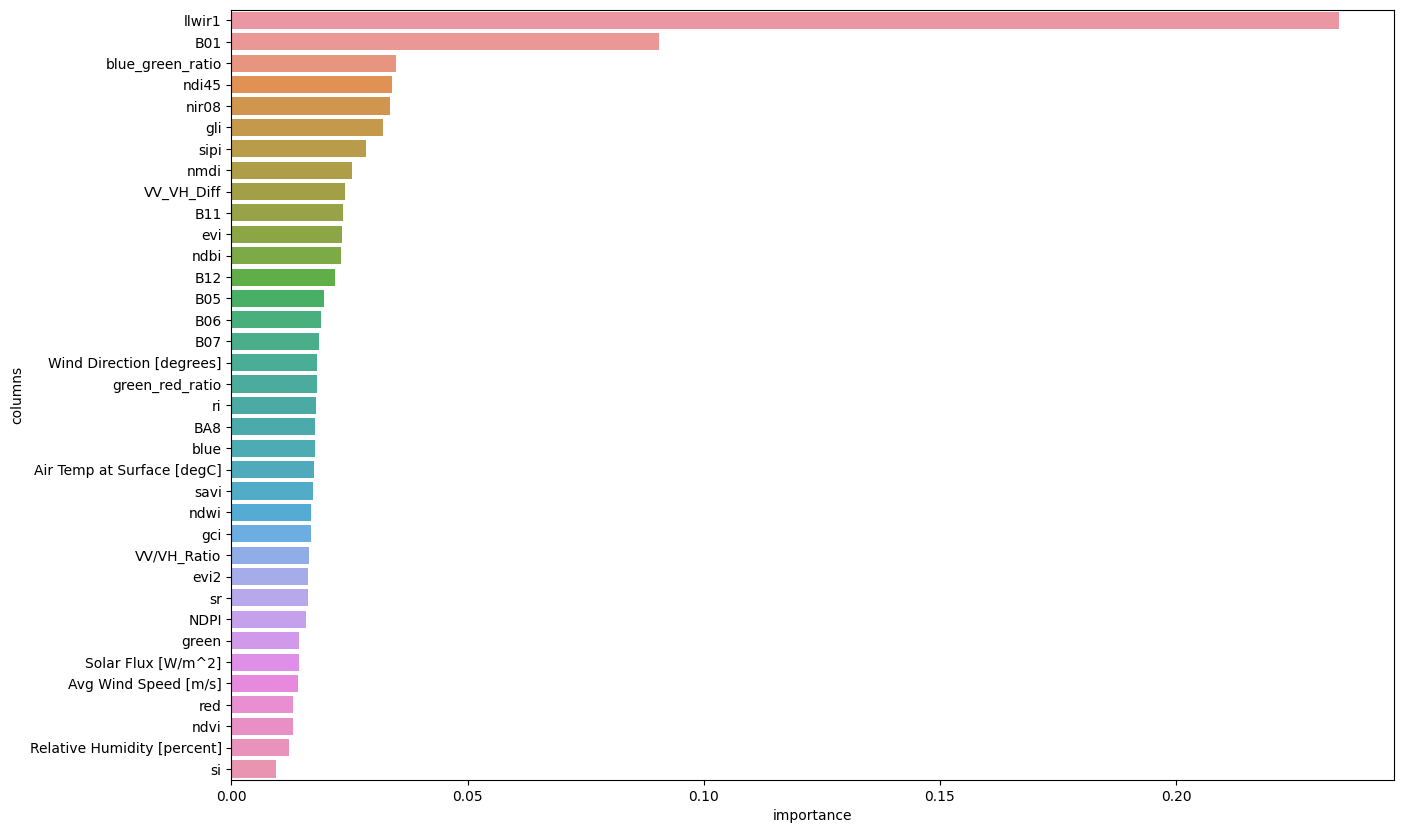

In [270]:
important_features=rf_model.feature_importances_
important_df=pd.DataFrame(important_features,columns=['importance'])
important_df['columns']=X.columns
plt.figure(figsize=(15,10))
sns.barplot(data=important_df.sort_values(by='importance',ascending=False).head(50),x='importance',y='columns')

## Model Evaluation

<p align="justify">Now that we have trained our model, the next step is to evaluate its performance. For evaluation, we will use the R² score, a common metric for regression models that measures how well the model explains the variance in the response variable (UHI index). Scikit-learn provides many other metrics that can be used for evaluation, and you can also write custom code for more specific evaluation needs.</p>


### In-Sample Evaluation
<p align="justify">We will be evaluating our model's performance using the R² score on the training data. It is important to note that this is in-sample performance testing, which involves evaluating the model on the training dataset. These metrics are not truly indicative of the model's ability to generalize. You should reserve testing on the test data before drawing final conclusions about your model's performance.</p>


<p align="justify">In this section, we make predictions on the training set and store them in the <b><i>insample_predictions</i></b> variable. The R² score is then calculated to gauge the model's performance on the training data. It is important to keep in mind that this evaluation is for the training set, and further testing on the test set is necessary to assess the model's generalizability.</p>


In [271]:
# Make predictions on the training data
insample_predictions = model.predict(X_train)

In [272]:
# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

0.9948178343813634

### Out-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will predict on the test data now. 

In [273]:
# Make predictions on the test data
outsample_predictions = model.predict(X_test)

In [274]:
# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

0.7521389213443953

<Axes: xlabel='importance', ylabel='columns'>

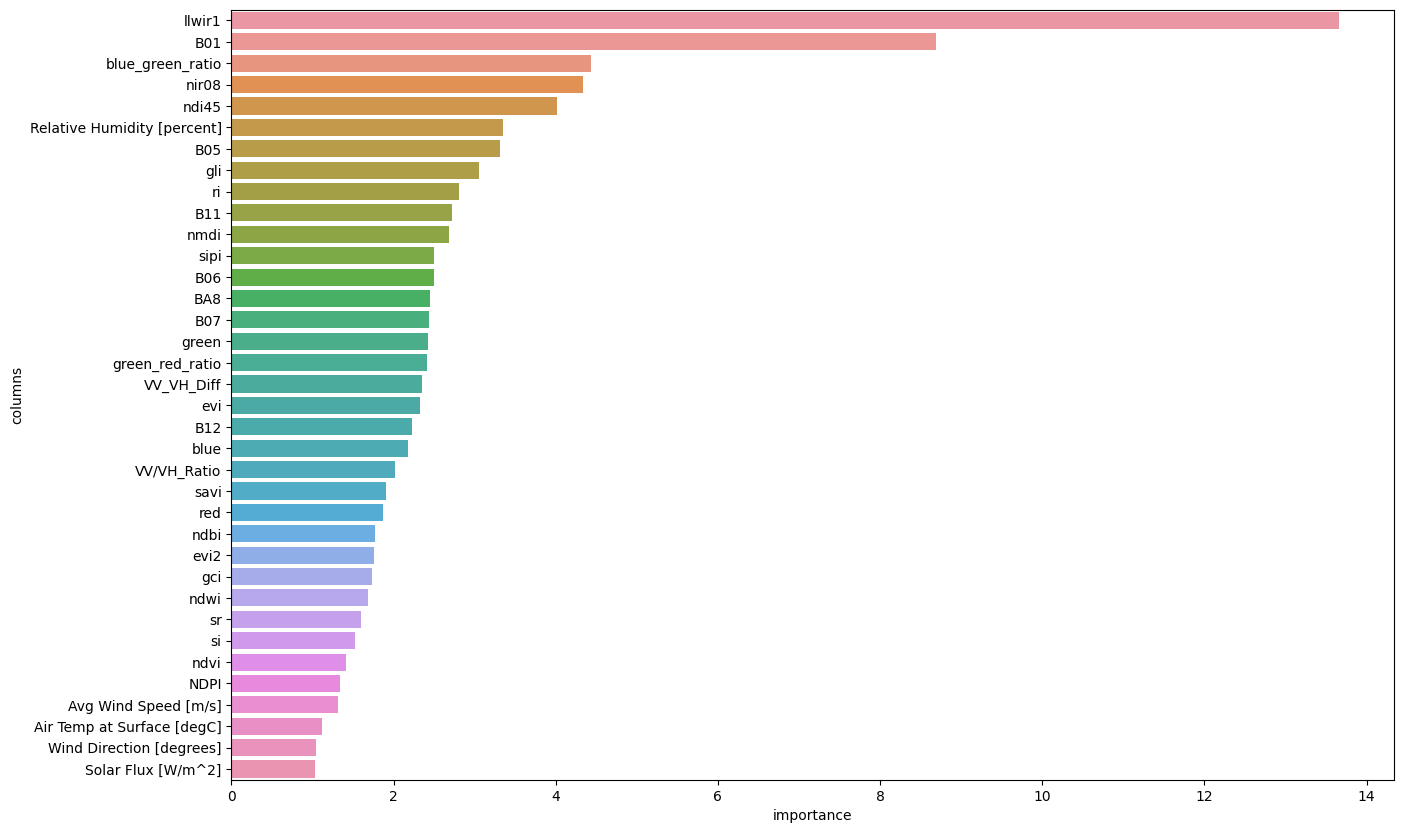

In [275]:
important_features=model.feature_importances_
important_df=pd.DataFrame(important_features,columns=['importance'])
important_df['columns']=X.columns
plt.figure(figsize=(15,10))
sns.barplot(data=important_df.sort_values(by='importance',ascending=False).head(50),x='importance',y='columns')

## Submission

Once you are satisfied with your model, you can proceed to make a submission. To do this, you will need to use your model to predict the Urban Heat Island (UHI) index for a set of test coordinates provided in the <b>"Submission_template.csv"</b> file and upload the results to the challenge platform.

In [276]:
#Reading the coordinates for the submission
test_file = pd.read_csv(Data_path+'Submission_template.csv')
test_file.shape

(1040, 3)

In [277]:
# Mapping satellite data for submission.
val_data = map_satellite_data(Data_path+'S2_nomedian_update_sample.tiff', Data_path+'Submission_template.csv')

Mapping values: 100%|██████████| 1040/1040 [00:16<00:00, 62.15it/s]


In [278]:
lst_test_data=map_satellite_data_LST(Data_path+'Landsat_median_update_LST.tiff', Data_path+'Submission_template.csv')

Mapping values: 100%|██████████| 1040/1040 [00:01<00:00, 714.00it/s]


In [279]:
additional_bands_test=map_satellite_data_additional(Data_path+'Additional_median_update_bands.tiff',Data_path+'Submission_template.csv')

Mapping values: 100%|██████████| 1040/1040 [00:05<00:00, 176.57it/s]


In [280]:
sentinel_data=map_sentinel_1_data(Data_path+'S1_median_update2_sample.tiff',Data_path+'Submission_template.csv')

Mapping values: 100%|██████████| 1040/1040 [00:03<00:00, 337.91it/s]


In [281]:
final_test_additional=pd.concat([val_data,lst_test_data,additional_bands_test,sentinel_data] , axis=1)
final_test_additional.head()

,B01,B02,B03,B04,B05,B06,B07,B08,BA8,B11,B12,llwir1,green,blue,red,nir08,vv,vh
0,1745.0,1421.0,1625.0,1488.0,1989.0,3291.0,3555.0,3614.0,3765.0,2658.0,2038.0,35.650980050000044,0.06529249999999998,0.04858625,0.0539075,0.2780325,2.6576218605041504,2.334155559539795
1,2151.0,1484.0,1701.0,1576.0,2153.0,3259.0,3652.0,4424.0,3785.0,2788.0,2184.0,35.650980050000044,0.06529249999999998,0.04858625,0.0539075,0.2780325,2.7408652305603027,2.4416604042053223
2,1985.0,1714.0,1874.0,1958.0,1829.0,2289.0,2485.0,2384.0,2538.0,2234.0,1931.0,34.39314869000003,0.10214250000000002,0.08197125,0.1109425,0.13809875,2.702409267425537,2.4030356407165527
3,2142.0,1874.0,1918.0,2134.0,2899.0,3025.0,2952.0,2438.0,3199.0,3573.0,3096.0,36.3943994,0.14919500000000002,0.12707125000000002,0.16795,0.23469250000000003,2.6705551147460938,2.3742799758911133
4,2065.0,1730.0,1870.0,1926.0,2403.0,3026.0,3285.0,3432.0,3342.0,3120.0,2620.0,34.54012355000003,0.15688125000000003,0.12113125000000002,0.16194124999999998,0.28680500000000003,2.581088066101074,2.2056162357330322


In [282]:
all_val=get_more_features(final_test_additional)
all_val.head()

,B01,B02,B03,B04,B05,B06,B07,B08,BA8,B11,B12,llwir1,green,blue,red,nir08,vv,vh,ndvi,evi,ndwi,ndbi,savi,evi2,sr,gci,sipi,nmdi,ri,gli,blue_green_ratio,green_red_ratio,ndi45,si,VV/VH_Ratio,VV_VH_Diff,NDPI
0,1745.0,1421.0,1625.0,1488.0,1989.0,3291.0,3555.0,3614.0,3765.0,2658.0,2038.0,35.650980050000044,0.06529249999999998,0.04858625,0.0539075,0.2780325,2.6576218605041504,2.334155559539795,0.675197,0.452931,-0.619646,0.999791,0.404101,0.398116,5.157584,3.25826,1.023742,-0.999104,0.825631,0.120523,0.744132,1.211195,0.051918,0.055929,1.13858,0.323466,0.0648
1,2151.0,1484.0,1701.0,1576.0,2153.0,3259.0,3652.0,4424.0,3785.0,2788.0,2184.0,35.650980050000044,0.06529249999999998,0.04858625,0.0539075,0.2780325,2.7408652305603027,2.4416604042053223,0.675197,0.452931,-0.619646,0.999801,0.404101,0.398116,5.157584,3.25826,1.023742,-0.99908,0.825631,0.120523,0.744132,1.211195,0.051918,0.055929,1.122542,0.299205,0.057733
2,1985.0,1714.0,1874.0,1958.0,1829.0,2289.0,2485.0,2384.0,2538.0,2234.0,1931.0,34.39314869000003,0.10214250000000002,0.08197125,0.1109425,0.13809875,2.702409267425537,2.4030356407165527,0.109043,0.0571,-0.149667,0.999876,0.054382,0.048343,1.244778,0.35202,2.066835,-0.999089,1.086154,0.028629,0.802518,0.92068,0.150177,0.098352,1.124581,0.299374,0.058638
3,2142.0,1874.0,1918.0,2134.0,2899.0,3025.0,2952.0,2438.0,3199.0,3573.0,3096.0,36.3943994,0.14919500000000002,0.12707125000000002,0.16795,0.23469250000000003,2.6705551147460938,2.3742799758911133,0.165761,0.12941,-0.222715,0.999869,0.110912,0.10188,1.397395,0.573059,1.612484,-0.999016,1.125708,0.005677,0.851712,0.88833,0.138562,0.148072,1.124785,0.296275,0.058728
4,2065.0,1730.0,1870.0,1926.0,2403.0,3026.0,3285.0,3432.0,3342.0,3120.0,2620.0,34.54012355000003,0.15688125000000003,0.12113125000000002,0.16194124999999998,0.28680500000000003,2.581088066101074,2.2056162357330322,0.27825,0.231235,-0.292828,0.999816,0.197414,0.186312,1.771043,0.828166,1.326836,-0.998853,1.032254,0.051421,0.772121,0.968754,0.144168,0.146651,1.170234,0.375472,0.078441


In [283]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
all_val['NDVI'] = (all_val['B08'] - all_val['B04']) / (all_val['B08'] + all_val['B04'])
all_val['NDVI'] = all_val['NDVI'].replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN

In [284]:
test_data=pd.concat([test_file,all_val],axis=1).drop('UHI Index',axis=1)

In [285]:
test_data.head()

,Longitude,Latitude,B01,B02,B03,B04,B05,B06,B07,B08,BA8,B11,B12,llwir1,green,blue,red,nir08,vv,vh,ndvi,evi,ndwi,ndbi,savi,evi2,sr,gci,sipi,nmdi,ri,gli,blue_green_ratio,green_red_ratio,ndi45,si,VV/VH_Ratio,VV_VH_Diff,NDPI
0,-73.971665,40.788763,1745.0,1421.0,1625.0,1488.0,1989.0,3291.0,3555.0,3614.0,3765.0,2658.0,2038.0,35.650980050000044,0.06529249999999998,0.04858625,0.0539075,0.2780325,2.6576218605041504,2.334155559539795,0.675197,0.452931,-0.619646,0.999791,0.404101,0.398116,5.157584,3.25826,1.023742,-0.999104,0.825631,0.120523,0.744132,1.211195,0.051918,0.055929,1.13858,0.323466,0.0648
1,-73.971928,40.788875,2151.0,1484.0,1701.0,1576.0,2153.0,3259.0,3652.0,4424.0,3785.0,2788.0,2184.0,35.650980050000044,0.06529249999999998,0.04858625,0.0539075,0.2780325,2.7408652305603027,2.4416604042053223,0.675197,0.452931,-0.619646,0.999801,0.404101,0.398116,5.157584,3.25826,1.023742,-0.99908,0.825631,0.120523,0.744132,1.211195,0.051918,0.055929,1.122542,0.299205,0.057733
2,-73.967080,40.789080,1985.0,1714.0,1874.0,1958.0,1829.0,2289.0,2485.0,2384.0,2538.0,2234.0,1931.0,34.39314869000003,0.10214250000000002,0.08197125,0.1109425,0.13809875,2.702409267425537,2.4030356407165527,0.109043,0.0571,-0.149667,0.999876,0.054382,0.048343,1.244778,0.35202,2.066835,-0.999089,1.086154,0.028629,0.802518,0.92068,0.150177,0.098352,1.124581,0.299374,0.058638
3,-73.972550,40.789082,2142.0,1874.0,1918.0,2134.0,2899.0,3025.0,2952.0,2438.0,3199.0,3573.0,3096.0,36.3943994,0.14919500000000002,0.12707125000000002,0.16795,0.23469250000000003,2.6705551147460938,2.3742799758911133,0.165761,0.12941,-0.222715,0.999869,0.110912,0.10188,1.397395,0.573059,1.612484,-0.999016,1.125708,0.005677,0.851712,0.88833,0.138562,0.148072,1.124785,0.296275,0.058728
4,-73.969697,40.787953,2065.0,1730.0,1870.0,1926.0,2403.0,3026.0,3285.0,3432.0,3342.0,3120.0,2620.0,34.54012355000003,0.15688125000000003,0.12113125000000002,0.16194124999999998,0.28680500000000003,2.581088066101074,2.2056162357330322,0.27825,0.231235,-0.292828,0.999816,0.197414,0.186312,1.771043,0.828166,1.326836,-0.998853,1.032254,0.051421,0.772121,0.968754,0.144168,0.146651,1.170234,0.375472,0.078441


In [288]:
test_data.head()

,Longitude,Latitude,B01,B02,B03,B04,B05,B06,B07,B08,BA8,B11,B12,llwir1,green,blue,red,nir08,vv,vh,ndvi,evi,ndwi,ndbi,savi,evi2,sr,gci,sipi,nmdi,ri,gli,blue_green_ratio,green_red_ratio,ndi45,si,VV/VH_Ratio,VV_VH_Diff,NDPI
0,-73.971665,40.788763,1745.0,1421.0,1625.0,1488.0,1989.0,3291.0,3555.0,3614.0,3765.0,2658.0,2038.0,35.650980050000044,0.06529249999999998,0.04858625,0.0539075,0.2780325,2.6576218605041504,2.334155559539795,0.675197,0.452931,-0.619646,0.999791,0.404101,0.398116,5.157584,3.25826,1.023742,-0.999104,0.825631,0.120523,0.744132,1.211195,0.051918,0.055929,1.13858,0.323466,0.0648
1,-73.971928,40.788875,2151.0,1484.0,1701.0,1576.0,2153.0,3259.0,3652.0,4424.0,3785.0,2788.0,2184.0,35.650980050000044,0.06529249999999998,0.04858625,0.0539075,0.2780325,2.7408652305603027,2.4416604042053223,0.675197,0.452931,-0.619646,0.999801,0.404101,0.398116,5.157584,3.25826,1.023742,-0.99908,0.825631,0.120523,0.744132,1.211195,0.051918,0.055929,1.122542,0.299205,0.057733
2,-73.967080,40.789080,1985.0,1714.0,1874.0,1958.0,1829.0,2289.0,2485.0,2384.0,2538.0,2234.0,1931.0,34.39314869000003,0.10214250000000002,0.08197125,0.1109425,0.13809875,2.702409267425537,2.4030356407165527,0.109043,0.0571,-0.149667,0.999876,0.054382,0.048343,1.244778,0.35202,2.066835,-0.999089,1.086154,0.028629,0.802518,0.92068,0.150177,0.098352,1.124581,0.299374,0.058638
3,-73.972550,40.789082,2142.0,1874.0,1918.0,2134.0,2899.0,3025.0,2952.0,2438.0,3199.0,3573.0,3096.0,36.3943994,0.14919500000000002,0.12707125000000002,0.16795,0.23469250000000003,2.6705551147460938,2.3742799758911133,0.165761,0.12941,-0.222715,0.999869,0.110912,0.10188,1.397395,0.573059,1.612484,-0.999016,1.125708,0.005677,0.851712,0.88833,0.138562,0.148072,1.124785,0.296275,0.058728
4,-73.969697,40.787953,2065.0,1730.0,1870.0,1926.0,2403.0,3026.0,3285.0,3432.0,3342.0,3120.0,2620.0,34.54012355000003,0.15688125000000003,0.12113125000000002,0.16194124999999998,0.28680500000000003,2.581088066101074,2.2056162357330322,0.27825,0.231235,-0.292828,0.999816,0.197414,0.186312,1.771043,0.828166,1.326836,-0.998853,1.032254,0.051421,0.772121,0.968754,0.144168,0.146651,1.170234,0.375472,0.078441


In [289]:
import pandas as pd
from scipy.spatial import cKDTree
import numpy as np

# Define known weather stations
weather_stations = pd.DataFrame({
    'Station': ['bronx', 'manhattan'],
    'Latitude': [40.87248, 40.76754],
    'Longitude': [-73.89352, -73.96449]
})


# Convert lat/lon to radians for Haversine calculation
weather_radians = np.radians(weather_stations[['Latitude', 'Longitude']])
train_radians = np.radians(test_data[['Latitude', 'Longitude']])

# Build KDTree for fast nearest neighbor search
tree_test = cKDTree(weather_radians)

# Find the nearest weather station for each test data point
_, nearest_idx = tree_test.query(train_radians)
test_data['Nearest_Station'] = weather_stations.iloc[nearest_idx]['Station'].values

# Aggregate weather data by station (e.g., mean values)
weather_avg = weather_df[mean_cols].groupby('Station').mean().reset_index()

# Merge test data with weather data based on nearest station
test_data = test_data.merge(weather_avg, left_on='Nearest_Station', right_on='Station',how='left')

test_data.head()

,Longitude,Latitude,B01,B02,B03,B04,B05,B06,B07,B08,BA8,B11,B12,llwir1,green,blue,red,nir08,vv,vh,ndvi,evi,ndwi,ndbi,savi,evi2,sr,gci,sipi,nmdi,ri,gli,blue_green_ratio,green_red_ratio,ndi45,si,VV/VH_Ratio,VV_VH_Diff,NDPI,Nearest_Station,Station,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2]
0,-73.971665,40.788763,1745.0,1421.0,1625.0,1488.0,1989.0,3291.0,3555.0,3614.0,3765.0,2658.0,2038.0,35.650980050000044,0.06529249999999998,0.04858625,0.0539075,0.2780325,2.6576218605041504,2.334155559539795,0.675197,0.452931,-0.619646,0.999791,0.404101,0.398116,5.157584,3.25826,1.023742,-0.999104,0.825631,0.120523,0.744132,1.211195,0.051918,0.055929,1.13858,0.323466,0.0648,manhattan,manhattan,25.198225,49.401775,1.931953,134.863905,380.0
1,-73.971928,40.788875,2151.0,1484.0,1701.0,1576.0,2153.0,3259.0,3652.0,4424.0,3785.0,2788.0,2184.0,35.650980050000044,0.06529249999999998,0.04858625,0.0539075,0.2780325,2.7408652305603027,2.4416604042053223,0.675197,0.452931,-0.619646,0.999801,0.404101,0.398116,5.157584,3.25826,1.023742,-0.99908,0.825631,0.120523,0.744132,1.211195,0.051918,0.055929,1.122542,0.299205,0.057733,manhattan,manhattan,25.198225,49.401775,1.931953,134.863905,380.0
2,-73.967080,40.789080,1985.0,1714.0,1874.0,1958.0,1829.0,2289.0,2485.0,2384.0,2538.0,2234.0,1931.0,34.39314869000003,0.10214250000000002,0.08197125,0.1109425,0.13809875,2.702409267425537,2.4030356407165527,0.109043,0.0571,-0.149667,0.999876,0.054382,0.048343,1.244778,0.35202,2.066835,-0.999089,1.086154,0.028629,0.802518,0.92068,0.150177,0.098352,1.124581,0.299374,0.058638,manhattan,manhattan,25.198225,49.401775,1.931953,134.863905,380.0
3,-73.972550,40.789082,2142.0,1874.0,1918.0,2134.0,2899.0,3025.0,2952.0,2438.0,3199.0,3573.0,3096.0,36.3943994,0.14919500000000002,0.12707125000000002,0.16795,0.23469250000000003,2.6705551147460938,2.3742799758911133,0.165761,0.12941,-0.222715,0.999869,0.110912,0.10188,1.397395,0.573059,1.612484,-0.999016,1.125708,0.005677,0.851712,0.88833,0.138562,0.148072,1.124785,0.296275,0.058728,manhattan,manhattan,25.198225,49.401775,1.931953,134.863905,380.0
4,-73.969697,40.787953,2065.0,1730.0,1870.0,1926.0,2403.0,3026.0,3285.0,3432.0,3342.0,3120.0,2620.0,34.54012355000003,0.15688125000000003,0.12113125000000002,0.16194124999999998,0.28680500000000003,2.581088066101074,2.2056162357330322,0.27825,0.231235,-0.292828,0.999816,0.197414,0.186312,1.771043,0.828166,1.326836,-0.998853,1.032254,0.051421,0.772121,0.968754,0.144168,0.146651,1.170234,0.375472,0.078441,manhattan,manhattan,25.198225,49.401775,1.931953,134.863905,380.0


In [292]:
test_data.shape

(1040, 46)

In [293]:
# Feature Scaling 
submission_val_data = submission_val_data.values
transformed_submission_data = sc.transform(submission_val_data)

In [294]:
transformed_submission_data

array([[-1.12311765e+00, -1.04772657e+00,  8.43733822e-01, ...,
        -8.98819805e-01,  8.98819805e-01, -8.98819805e-01],
       [-7.59043167e-04, -7.20834255e-01,  7.76832038e-01, ...,
        -8.98819805e-01,  8.98819805e-01, -8.98819805e-01],
       [-4.59654435e-01, -1.36664589e+00, -1.25112830e+00, ...,
        -8.98819805e-01,  8.98819805e-01, -8.98819805e-01],
       ...,
       [-2.74437620e-01,  1.28288456e-01,  4.98771497e-01, ...,
         1.11257006e+00, -1.11257006e+00,  1.11257006e+00],
       [ 1.32063853e+00,  1.14484381e+00,  1.08834347e+00, ...,
         1.11257006e+00, -1.11257006e+00,  1.11257006e+00],
       [ 4.07074079e-02,  2.67815662e-01, -4.58760289e-01, ...,
        -8.98819805e-01,  8.98819805e-01, -8.98819805e-01]])

In [295]:
#Making predictions
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [296]:
rf_predictions=rf_model.predict(transformed_submission_data)
rf_final_prediction_series = pd.Series(rf_predictions)

In [297]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [298]:
#Combining the results into dataframe
submission_df_rf = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':rf_final_prediction_series.values})

In [299]:
#Displaying the sample submission dataframe
submission_df.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.966514
1,-73.971928,40.788875,0.962446
2,-73.967080,40.789080,0.970902
3,-73.972550,40.789082,0.966468
4,-73.969697,40.787953,0.960599


In [300]:
submission_df_rf.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.970772
1,-73.971928,40.788875,0.968052
2,-73.967080,40.789080,0.973921
3,-73.972550,40.789082,0.969478
4,-73.969697,40.787953,0.969095


In [301]:
submission_df['UHI Index'].describe()

count    1040.000000
mean        0.999806
std         0.014131
min         0.960599
25%         0.990478
50%         1.000276
75%         1.009443
max         1.043017
Name: UHI Index, dtype: float64

In [302]:
submission_df_rf['UHI Index'].describe()

count    1040.000000
mean        0.999697
std         0.012737
min         0.966298
25%         0.990851
50%         1.000919
75%         1.008500
max         1.036245
Name: UHI Index, dtype: float64

<Axes: xlabel='UHI Index', ylabel='Density'>

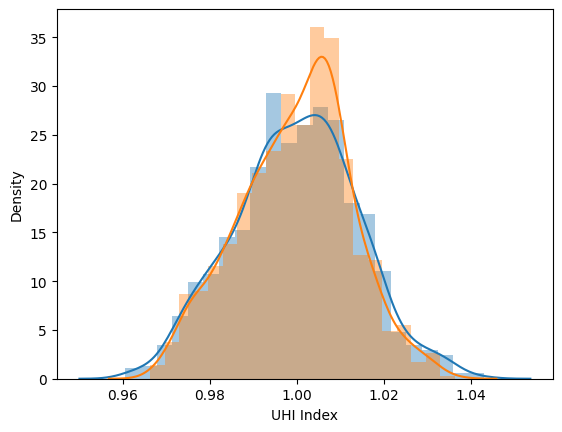

In [303]:
sns.distplot(submission_df['UHI Index'])
sns.distplot(submission_df_rf['UHI Index'])

In [ ]:
#Dumping the predictions into a csv file.
submission_df.to_csv("Baseline_scaler_update6.csv",index = False)

In [304]:
ensemble=submission_df.copy()
ensemble['UHI Index'] = (submission_df['UHI Index'] + submission_df_rf['UHI Index'])/2
ensemble

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.968643
1,-73.971928,40.788875,0.965249
2,-73.967080,40.789080,0.972411
3,-73.972550,40.789082,0.967973
4,-73.969697,40.787953,0.964847
...,...,...,...
1035,-73.919388,40.813803,1.019514
1036,-73.931033,40.833178,1.009588
1037,-73.934647,40.854542,1.030064
1038,-73.917223,40.815413,1.022557


<Axes: xlabel='UHI Index', ylabel='Density'>

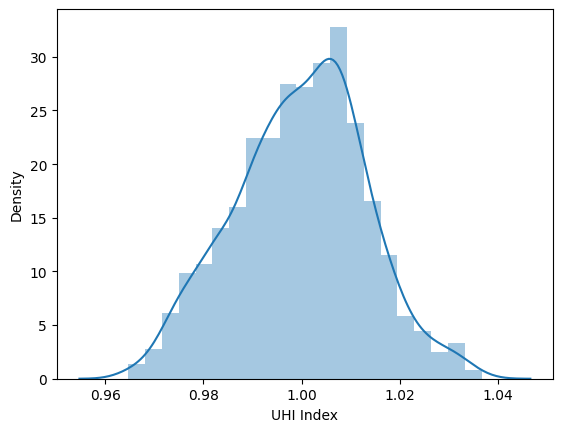

In [305]:
sns.distplot(ensemble['UHI Index'])

In [306]:
ensemble.to_csv('ENSEMBLE_CAT_RF2.csv',index=False)

### KFOLD

In [362]:
from sklearn.model_selection._split import GroupKFold,KFold


R2=[]
rf_score_ls=[]
cat_subs=[]
rf_subs=[]
fold= KFold(n_splits=20,shuffle=True,random_state=42)

for fold,(train_index,test_index) in enumerate(fold.split(X,y)):
    print('_'*50)
    print(f'FOLD : {fold+1}')
    
    X_train_k,X_test_k=X.iloc[train_index],X.iloc[test_index]
    y_train_k,y_test_k=y.iloc[train_index],y.iloc[test_index]
    
    cat_model=CatBoostRegressor(**cat_params,random_state=42,iterations=1000)
    cat_model.fit(X_train_k,y_train_k,verbose=100)
    
    preds=cat_model.predict(X_test_k)

    rf_model = RandomForestRegressor(n_estimators=100,random_state=42,)
    rf_model.fit(X_train,y_train)
    
    rf_preds=rf_model.predict(X_test_k)

    score=r2_score(y_test_k,preds)
    rf_score=r2_score(y_test_k,rf_preds)
    
    print(f'CAT: R2 score for Fold {fold+1}: {score}')
    R2.append(score)

    print(f'RF: R2 score for Fold {fold+1}: {rf_score}')
    rf_score_ls.append(rf_score)
    
    predictions=cat_model.predict(transformed_submission_data)
    cat_subs.append(predictions)

    rf_predictions=rf_model.predict(transformed_submission_data)
    rf_subs.append(rf_predictions)
    
print('CAT:Average RMSE:{}'.format(np.mean(R2)))
print('RF:Average RMSE:{}'.format(np.mean(rf_subs)))

__________________________________________________
FOLD : 1
0:	learn: 0.0156580	total: 23.5ms	remaining: 23.4s
100:	learn: 0.0092185	total: 1.45s	remaining: 12.9s
200:	learn: 0.0066370	total: 2.88s	remaining: 11.4s
300:	learn: 0.0050822	total: 4.32s	remaining: 10s
400:	learn: 0.0039546	total: 5.75s	remaining: 8.59s
500:	learn: 0.0031974	total: 7.21s	remaining: 7.18s
600:	learn: 0.0026331	total: 8.67s	remaining: 5.75s
700:	learn: 0.0021944	total: 10.1s	remaining: 4.31s
800:	learn: 0.0018645	total: 11.6s	remaining: 2.87s
900:	learn: 0.0016261	total: 13s	remaining: 1.43s
999:	learn: 0.0014210	total: 14.8s	remaining: 0us
CAT: R2 score for Fold 1: 0.7724537293971374
RF: R2 score for Fold 1: 0.864176062060027
__________________________________________________
FOLD : 2
0:	learn: 0.0156879	total: 23.7ms	remaining: 23.7s
100:	learn: 0.0093166	total: 1.45s	remaining: 12.9s
200:	learn: 0.0066172	total: 2.92s	remaining: 11.6s
300:	learn: 0.0050801	total: 4.36s	remaining: 10.1s
400:	learn: 0.004028

In [363]:
print('Average RMSE:{}'.format(np.mean(R2)))

Average RMSE:0.8026105659951671


In [364]:
len(cat_subs) , len(cat_subs)

(20, 20)

In [365]:
cat_subs

[array([0.96920153, 0.96775604, 0.96874382, ..., 1.03437418, 1.02420703,
        1.02905419]),
 array([0.97778691, 0.97171752, 0.97812939, ..., 1.0299187 , 1.02795135,
        1.02302273]),
 array([0.97705177, 0.96576206, 0.97187731, ..., 1.02337248, 1.02981884,
        1.02227548]),
 array([0.97946686, 0.97134698, 0.97599997, ..., 1.02592842, 1.02299334,
        1.02642434]),
 array([0.97362041, 0.97253747, 0.97702767, ..., 1.0306118 , 1.02528995,
        1.02573537]),
 array([0.97638343, 0.97192113, 0.97302302, ..., 1.02683003, 1.02673722,
        1.0290698 ]),
 array([0.98285863, 0.97001971, 0.97065314, ..., 1.0278999 , 1.0279648 ,
        1.02526718]),
 array([0.98128972, 0.97656889, 0.97428308, ..., 1.02628494, 1.02743987,
        1.02962164]),
 array([0.96979877, 0.96642311, 0.9739688 , ..., 1.02784042, 1.0235525 ,
        1.02618629]),
 array([0.97282318, 0.96766516, 0.96981418, ..., 1.03096068, 1.02876682,
        1.03053558]),
 array([0.97795133, 0.97125782, 0.9719011 , ..., 1

In [366]:
rf_subs

[array([0.97077232, 0.96805205, 0.97392052, ..., 1.02531957, 1.02059666,
        1.02071807]),
 array([0.97077232, 0.96805205, 0.97392052, ..., 1.02531957, 1.02059666,
        1.02071807]),
 array([0.97077232, 0.96805205, 0.97392052, ..., 1.02531957, 1.02059666,
        1.02071807]),
 array([0.97077232, 0.96805205, 0.97392052, ..., 1.02531957, 1.02059666,
        1.02071807]),
 array([0.97077232, 0.96805205, 0.97392052, ..., 1.02531957, 1.02059666,
        1.02071807]),
 array([0.97077232, 0.96805205, 0.97392052, ..., 1.02531957, 1.02059666,
        1.02071807]),
 array([0.97077232, 0.96805205, 0.97392052, ..., 1.02531957, 1.02059666,
        1.02071807]),
 array([0.97077232, 0.96805205, 0.97392052, ..., 1.02531957, 1.02059666,
        1.02071807]),
 array([0.97077232, 0.96805205, 0.97392052, ..., 1.02531957, 1.02059666,
        1.02071807]),
 array([0.97077232, 0.96805205, 0.97392052, ..., 1.02531957, 1.02059666,
        1.02071807]),
 array([0.97077232, 0.96805205, 0.97392052, ..., 1

In [373]:
kfold_predictions=np.mean(rf_subs+cat_subs,axis=0)

In [374]:
#Combining the results into dataframe
kf_submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':kfold_predictions})

In [375]:
kf_submission_df.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.974271
1,-73.971928,40.788875,0.969347
2,-73.967080,40.789080,0.973900
3,-73.972550,40.789082,0.970570
4,-73.969697,40.787953,0.967489


In [376]:
kf_submission_df['UHI Index'].describe()

count    1040.000000
mean        0.999716
std         0.012942
min         0.964309
25%         0.990724
50%         1.000618
75%         1.008615
max         1.035994
Name: UHI Index, dtype: float64

<Axes: xlabel='UHI Index', ylabel='Density'>

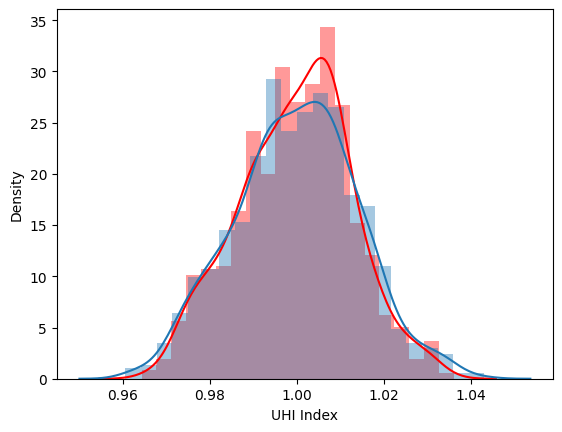

In [377]:
sns.distplot(kf_submission_df['UHI Index'],color='red')
sns.distplot(submission_df['UHI Index'])

In [378]:
kf_submission_df.to_csv('KFBase_Ensmble .csv', index=False)

### StratifiedKFold

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
train_skf=new_data.copy()

In [ ]:
sc_cols=[col for col in train_skf.columns if col not in ['UHI Index']]

In [ ]:
train_skf[sc_cols]=sc.fit_transform(train_skf[sc_cols])

In [ ]:
train_skf['UHI Index']

In [ ]:
def create_folds(df, n_grp, n_splits):
    #create fold labels based on the bin groups
    df['Fold'] = -1
    skf = StratifiedKFold(n_splits=n_splits)
    df['grp'] = pd.cut(df['UHI Index'], n_grp, labels=False)
    target = df.grp
    for fold_no, (t, v) in enumerate(skf.split(df, target)):
        df.loc[v, 'Fold'] = fold_no
    return df

In [ ]:
Train_skf=create_folds(train_skf,10,10)

In [ ]:
Train_skf.Fold.value_counts()

In [ ]:
Train_skf

In [ ]:

#build the model

X = Train_skf.drop('UHI Index',axis=1)
y = Train_skf['UHI Index']

features=[column for column in X.columns if column not in ['Fold','grp']]
cv_score = []

test_sub=[]

for i in range(9):

    train_data=Train_skf[Train_skf['Fold'] != i ]
    X_train_skf=train_data[features]
    y_train_skf=train_data['UHI Index']

    validation_data=Train_skf[Train_skf['Fold'] == i]
    X_test_skf=validation_data[features]
    y_test_skf = validation_data['UHI Index']

    lgbm_model=RandomForestRegressor(n_estimators=200,random_state=42)
    lgbm_model.fit(X_train_skf,y_train_skf)

    val_preds=lgbm_model.predict(X_test_skf)

    val_score=r2_score(y_test_skf,val_preds)

    cv_score.append(val_score)

    print('CV score for fold {} : {}'.format(i+1,val_score))

    test_preds=lgbm_model.predict(transformed_submission_data)
    test_sub.append(test_preds)

print(f'CV mean {np.mean(cv_score)}')